# Team Based Model

## Imports

In [31]:

import sqlite3
import joblib
import optuna

import pandas as pd
# import plotly.graph_objects as go
# import plotly.express as px

from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import learning_curve, validation_curve
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import VarianceThreshold, RFE, RFECV, SequentialFeatureSelector, SelectKBest
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import Normalizer, StandardScaler
from sklearn.model_selection import cross_val_score

import xgboost as xgb
from sklearn.svm import LinearSVR
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import ElasticNet, LinearRegression, SGDRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split, TimeSeriesSplit

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import pointbiserialr
from sklearn.compose import ColumnTransformer
import seaborn as sns



# import tensorflow as tf 
# from tensorflow import keras
# from tensorflow.keras import layers

from sklearn.feature_selection import SequentialFeatureSelector, RFE, RFECV
from tqdm import tqdm
from nba_api.stats.static import players, teams

import sys

%load_ext autoreload
%autoreload 2

sys.path.append("..")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
pd.options.display.max_columns=230
pd.options.display.max_rows=120

In [3]:
connection = sqlite3.connect('../data/nba.db')


df = pd.read_sql('SELECT * FROM team_stats_ewa_matchup', con=connection)
df = df.drop(columns=['index'])

connection.close()

In [4]:
df

,SEASON,HOME_TEAM_ABBREVIATION,GAME_DATE,GAME_ID,MATCHUP,HOME_HOME_GAME,HOME_TEAM_SCORE,HOME_ML,HOME_SPREAD,HOME_ATS_DIFF,HOME_TEAM_COVERED,HOME_POINT_DIFF,HOME_WL,HOME_FG2M_L5,HOME_FG2A_L5,HOME_FG3M_L5,HOME_FG3A_L5,HOME_FTM_L5,HOME_FTA_L5,HOME_OREB_L5,HOME_DREB_L5,HOME_REB_L5,HOME_AST_L5,HOME_STL_L5,HOME_BLK_L5,HOME_TOV_L5,HOME_PF_L5,HOME_PTS_L5,HOME_PLUS_MINUS_L5,HOME_OFF_RATING_L5,HOME_DEF_RATING_L5,HOME_NET_RATING_L5,HOME_PACE_L5,HOME_POSS_L5,HOME_DIST_L5,HOME_ORBC_L5,HOME_DRBC_L5,HOME_RBC_L5,HOME_TCHS_L5,HOME_SAST_L5,HOME_FTAST_L5,HOME_PASS_L5,HOME_CFGM_L5,HOME_CFGA_L5,HOME_UFGM_L5,HOME_UFGA_L5,HOME_DFGM_L5,HOME_DFGA_L5,HOME_PTS_2PT_MR_L5,HOME_PTS_FB_L5,HOME_PTS_OFF_TOV_L5,HOME_PTS_PAINT_L5,HOME_AST_2PM_L5,HOME_AST_3PM_L5,HOME_UAST_2PM_L5,HOME_UAST_3PM_L5,HOME_FG2M_opp_L5,HOME_FG2A_opp_L5,HOME_FG3M_opp_L5,HOME_FG3A_opp_L5,HOME_FTM_opp_L5,HOME_FTA_opp_L5,HOME_OREB_opp_L5,HOME_DREB_opp_L5,HOME_REB_opp_L5,HOME_AST_opp_L5,HOME_STL_opp_L5,HOME_BLK_opp_L5,HOME_TOV_opp_L5,HOME_PF_opp_L5,HOME_PTS_opp_L5,HOME_PLUS_MINUS_opp_L5,HOME_OFF_RATING_opp_L5,HOME_DEF_RATING_opp_L5,HOME_NET_RATING_opp_L5,HOME_PACE_opp_L5,HOME_POSS_opp_L5,HOME_DIST_opp_L5,HOME_ORBC_opp_L5,HOME_DRBC_opp_L5,HOME_RBC_opp_L5,HOME_TCHS_opp_L5,HOME_SAST_opp_L5,HOME_FTAST_opp_L5,HOME_PASS_opp_L5,HOME_CFGM_opp_L5,HOME_CFGA_opp_L5,HOME_UFGM_opp_L5,HOME_UFGA_opp_L5,HOME_DFGM_opp_L5,HOME_DFGA_opp_L5,HOME_PTS_2PT_MR_opp_L5,HOME_PTS_FB_opp_L5,HOME_PTS_OFF_TOV_opp_L5,HOME_PTS_PAINT_opp_L5,HOME_AST_2PM_opp_L5,HOME_AST_3PM_opp_L5,HOME_UAST_2PM_opp_L5,HOME_UAST_3PM_opp_L5,HOME_AVG_ATS_DIFF_L5,HOME_WIN_PCT_L5,HOME_COVER_PCT_L5,HOME_OREB_PCT_L5,HOME_OREB_PCT_opp_L5,HOME_DREB_PCT_L5,HOME_DREB_PCT_opp_L5,HOME_REB_PCT_L5,HOME_REB_PCT_opp_L5,HOME_TS_PCT_L5,HOME_TS_PCT_opp_L5,HOME_EFG_PCT_L5,HOME_EFG_PCT_opp_L5,HOME_AST_RATIO_L5,HOME_AST_RATIO_opp_L5,HOME_TOV_PCT_L5,...,AWAY_REB_PCT_opp_L10,AWAY_TS_PCT_L10,AWAY_TS_PCT_opp_L10,AWAY_EFG_PCT_L10,AWAY_EFG_PCT_opp_L10,AWAY_AST_RATIO_L10,AWAY_AST_RATIO_opp_L10,AWAY_TOV_PCT_L10,AWAY_TOV_PCT_opp_L10,AWAY_PIE_L10,AWAY_FG2M_L20,AWAY_FG2A_L20,AWAY_FG3M_L20,AWAY_FG3A_L20,AWAY_FTM_L20,AWAY_FTA_L20,AWAY_OREB_L20,AWAY_DREB_L20,AWAY_REB_L20,AWAY_AST_L20,AWAY_STL_L20,AWAY_BLK_L20,AWAY_TOV_L20,AWAY_PF_L20,AWAY_PTS_L20,AWAY_PLUS_MINUS_L20,AWAY_OFF_RATING_L20,AWAY_DEF_RATING_L20,AWAY_NET_RATING_L20,AWAY_PACE_L20,AWAY_POSS_L20,AWAY_DIST_L20,AWAY_ORBC_L20,AWAY_DRBC_L20,AWAY_RBC_L20,AWAY_TCHS_L20,AWAY_SAST_L20,AWAY_FTAST_L20,AWAY_PASS_L20,AWAY_CFGM_L20,AWAY_CFGA_L20,AWAY_UFGM_L20,AWAY_UFGA_L20,AWAY_DFGM_L20,AWAY_DFGA_L20,AWAY_PTS_2PT_MR_L20,AWAY_PTS_FB_L20,AWAY_PTS_OFF_TOV_L20,AWAY_PTS_PAINT_L20,AWAY_AST_2PM_L20,AWAY_AST_3PM_L20,AWAY_UAST_2PM_L20,AWAY_UAST_3PM_L20,AWAY_FG2M_opp_L20,AWAY_FG2A_opp_L20,AWAY_FG3M_opp_L20,AWAY_FG3A_opp_L20,AWAY_FTM_opp_L20,AWAY_FTA_opp_L20,AWAY_OREB_opp_L20,AWAY_DREB_opp_L20,AWAY_REB_opp_L20,AWAY_AST_opp_L20,AWAY_STL_opp_L20,AWAY_BLK_opp_L20,AWAY_TOV_opp_L20,AWAY_PF_opp_L20,AWAY_PTS_opp_L20,AWAY_PLUS_MINUS_opp_L20,AWAY_OFF_RATING_opp_L20,AWAY_DEF_RATING_opp_L20,AWAY_NET_RATING_opp_L20,AWAY_PACE_opp_L20,AWAY_POSS_opp_L20,AWAY_DIST_opp_L20,AWAY_ORBC_opp_L20,AWAY_DRBC_opp_L20,AWAY_RBC_opp_L20,AWAY_TCHS_opp_L20,AWAY_SAST_opp_L20,AWAY_FTAST_opp_L20,AWAY_PASS_opp_L20,AWAY_CFGM_opp_L20,AWAY_CFGA_opp_L20,AWAY_UFGM_opp_L20,AWAY_UFGA_opp_L20,AWAY_DFGM_opp_L20,AWAY_DFGA_opp_L20,AWAY_PTS_2PT_MR_opp_L20,AWAY_PTS_FB_opp_L20,AWAY_PTS_OFF_TOV_opp_L20,AWAY_PTS_PAINT_opp_L20,AWAY_AST_2PM_opp_L20,AWAY_AST_3PM_opp_L20,AWAY_UAST_2PM_opp_L20,AWAY_UAST_3PM_opp_L20,AWAY_AVG_ATS_DIFF_L20,AWAY_WIN_PCT_L20,AWAY_COVER_PCT_L20,AWAY_OREB_PCT_L20,AWAY_OREB_PCT_opp_L20,AWAY_DREB_PCT_L20,AWAY_DREB_PCT_opp_L20,AWAY_REB_PCT_L20,AWAY_REB_PCT_opp_L20,AWAY_TS_PCT_L20,AWAY_TS_PCT_opp_L20,AWAY_EFG_PCT_L20,AWAY_EFG_PCT_opp_L20,AWAY_AST_RATIO_L20,AWAY_AST_RATIO_opp_L20,AWAY_TOV_PCT_L20,AWAY_TOV_PCT_opp_L20,AWAY_PIE_L20,AWAY_REST
0,2013-14,IND,2013-10-29 00:00:00,0021300001,IND vs. ORL,1,97,8.600000,12.5,2.5,1,10,1,28.723404,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

In [56]:
df = df.sort_values('GAME_DATE')

df = df.dropna()
df = df.drop(columns=['AWAY_ML'])

train_df = df.loc[df['SEASON'] < '2019-20']
val_df = df.loc[df['SEASON'].between('2019-20', '2020-21')]
test_df = df.loc[df['SEASON'] >= '2021-22']


X_train = train_df.iloc[:, 13:]
y_train = train_df['HOME_WL']

X_val = val_df.iloc[:, 13:]
y_val = val_df['HOME_WL']

X_test = test_df.iloc[:, 13:]
y_test = test_df['HOME_WL']

train_df.shape, val_df.shape, test_df.shape

((7458, 639), (2263, 639), (1234, 639))

In [83]:
train_df.iloc[:, :13]


,SEASON,HOME_TEAM_ABBREVIATION,GAME_DATE,GAME_ID,MATCHUP,HOME_HOME_GAME,HOME_TEAM_SCORE,HOME_ML,HOME_SPREAD,HOME_ATS_DIFF,HOME_TEAM_COVERED,HOME_POINT_DIFF,HOME_WL
296,2013-14,POR,2013-12-07 00:00:00,0021300298,POR vs. DAL,1,106,2.900000,5.5,7.5,1,-2,0
298,2013-14,DET,2013-12-08 00:00:00,0021300300,DET vs. MIA,1,95,1.588235,-4.0,11.0,1,-15,0
302,2013-14,CHA,2013-12-09 00:00:00,0021300304,CHA vs. GSW,1,115,1.400000,-6.0,-10.0,0,4,1
303,2013-14,PHI,2013-12-09 00:00:00,0021300305,PHI vs. LAC,1,83,1.166667,-10.0,1.0,1,-11,0
306,2013-14,UTA,2013-12-09 00:00:00,0021300308,UTA vs. POR,1,94,1.312500,-8.0,3.0,1,-11,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7874,2018-19,TOR,2019-06-02 00:00:00,0041800402,TOR vs. GSW,1,104,2.100000,2.5,7.5,1,-5,0
7875,2018-19,GSW,2019-06-05 00:00:00,0041800403,GSW vs. TOR,1,109,2.200000,3.0,17.0,1,-14,0
7876,2018-19,GSW,2019-06-07 00:00:00,0041800404,GSW vs. TOR,1,92,2.950000,5.0,18.0,1,-13,0
7877,2018-19,TOR,2019-06-10 00:00:00,0041800405,TOR vs. GSW,1,105,3.150000,-1.0,0.0,0,-1,0


In [57]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import TimeSeriesSplit, cross_validate
from sklearn.linear_model import LogisticRegression

def print_metrics(model, X_train, X_test, y_train, y_test, cv, scoring):
    cv_results = cross_validate(model, X_train, y_train, cv=cv, scoring=scoring)
    

    print("Model:", model)
    print(f"CV Split {str(scoring)}:", cv_results['test_score'])
    print(f"Mean {str(scoring)}:", cv_results['test_score'].mean())    
    
    
    return None




In [58]:
lr_pipe = Pipeline([('scaler', StandardScaler()),
                    ('lr', LogisticRegression(max_iter=10000))])
          
print_metrics(lr_pipe, X_train, X_val, y_train, y_val, cv=TimeSeriesSplit(5), scoring='accuracy')


Model: Pipeline(steps=[('scaler', StandardScaler()),
                ('lr', LogisticRegression(max_iter=10000))])
CV Split accuracy: [0.64360418 0.69670153 0.67015286 0.66452132 0.68543846]
Mean accuracy: 0.6720836685438455


In [59]:
lr_pipe.fit(X_train, y_train)
coefficients= pd.DataFrame({'features':X_train.columns,
                      'coefficients': list(lr_pipe.named_steps['lr'].coef_)[0]})

coefficients.sort_values(['coefficients'], ascending=False)

,features,coefficients
365,AWAY_AST_opp_L5,0.803791
140,HOME_PTS_FB_L10,0.789732
168,HOME_DIST_opp_L10,0.788174
103,HOME_PIE_L5,0.774788
230,HOME_ORBC_L20,0.770055
...,...,...
213,HOME_FTA_L20,-0.704908
115,HOME_BLK_L10,-0.705033
559,AWAY_PTS_PAINT_L20,-0.862086
126,HOME_ORBC_L10,-0.915781


## Feature Engineering

## Helper Functions for Bet Simulations

In [60]:
def simulate_bets_1(selected_bets, unit_size):
    """This function simulates betting unit_size of your bankroll on each bet in the
    selected_bets df"""
    selected_bets = selected_bets.copy()
    selected_bets = selected_bets.reset_index()
    selected_bets.loc[0, 'bankroll_i'] = 100
    for idx in range(selected_bets.shape[0]):
        if np.isnan(selected_bets.loc[idx, 'bankroll_i']):
            selected_bets.loc[idx, 'bankroll_i'] = selected_bets.loc[idx-1, 'bankroll_n']

        selected_bets.loc[idx, 'bet_size'] = unit_size
        if selected_bets.loc[idx, 'bet_won'] == 1:
            selected_bets.loc[idx, 'bankroll_n'] = selected_bets.loc[idx, 'bankroll_i'] + (1/1.1)*selected_bets.loc[idx, 'bet_size']
        elif selected_bets.loc[idx, 'bet_won'] == 0:
            selected_bets.loc[idx, 'bankroll_n'] = selected_bets.loc[idx, 'bankroll_i'] - selected_bets.loc[idx, 'bet_size']
        else:
            selected_bets.loc[idx, 'bankroll_n'] = selected_bets.loc[idx, 'bankroll_i']
            
    plt.style.use('fivethirtyeight')

    fig, ax = plt.subplots(figsize=(12, 8))

    ax.plot(range(selected_bets.shape[0]), selected_bets['bankroll_i'], linewidth=1.5)
    ax.set_ylabel("Bankroll")
    ax.set_xlabel("Games Bet")
    plt.show()
    min_balance = selected_bets['bankroll_n'].min()
    max_balance = selected_bets['bankroll_n'].max()
    final_balance = selected_bets['bankroll_n'].iloc[-1]
    win_pct = selected_bets.loc[selected_bets['bet_won'] != 0.5, 'bet_won'].mean()
    
    amt_won = selected_bets.loc[selected_bets['bet_won'] ==1, 'bet_size'].sum() * 1/1.1
    amt_lost = selected_bets.loc[selected_bets['bet_won']==0, 'bet_size'].sum()
    amt_risked = selected_bets['bet_size'].sum()

    profit = amt_won - amt_lost
    roi = profit/amt_risked
    
    print("min balance:", min_balance,
         "\nmax balance:", max_balance,
         "\nfinal balance:", final_balance,
         "\nwin percentage", round(win_pct, 4) * 100,
         "\nprofit:", profit, "risk:", amt_risked,
         "\nROI:", round(roi, 4) * 100)
    return selected_bets, roi, profit, win_pct

def simulate_bets_2(selected_bets, unit_pct=0.03):
    """This function simulates betting unit_size (default 3%) of your bankroll on each bet in the
    selected_bets df"""
    selected_bets = selected_bets.copy()
    selected_bets = selected_bets.reset_index()
    selected_bets.loc[0, 'bankroll_i'] = 100
    for idx in range(selected_bets.shape[0]):
        if np.isnan(selected_bets.loc[idx, 'bankroll_i']):
            selected_bets.loc[idx, 'bankroll_i'] = selected_bets.loc[idx-1, 'bankroll_n']

        selected_bets.loc[idx, 'bet_size'] = selected_bets.loc[idx, 'bankroll_i'] * unit_pct
        if selected_bets.loc[idx, 'bet_won'] == 1:
            selected_bets.loc[idx, 'bankroll_n'] = selected_bets.loc[idx, 'bankroll_i'] + (1/1.1)*selected_bets.loc[idx, 'bet_size']
        elif selected_bets.loc[idx, 'bet_won'] == 0:
            selected_bets.loc[idx, 'bankroll_n'] = selected_bets.loc[idx, 'bankroll_i'] - selected_bets.loc[idx, 'bet_size']
        else:
            selected_bets.loc[idx, 'bankroll_n'] = selected_bets.loc[idx, 'bankroll_i']
            
    plt.style.use('fivethirtyeight')

    fig, ax = plt.subplots(figsize=(12, 8))

    ax.plot(range(selected_bets.shape[0]), selected_bets['bankroll_i'], linewidth=1.5)
    ax.set_ylabel("Bankroll")
    ax.set_xlabel("Games Bet")
    plt.show()
    min_balance = selected_bets['bankroll_n'].min()
    max_balance = selected_bets['bankroll_n'].max()
    final_balance = selected_bets['bankroll_n'].iloc[-1]
    win_pct = selected_bets.loc[selected_bets['bet_won'] != 0.5, 'bet_won'].mean()
    
    amt_won = selected_bets.loc[selected_bets['bet_won'] ==1, 'bet_size'].sum() * 1/1.1
    amt_lost = selected_bets.loc[selected_bets['bet_won']==0, 'bet_size'].sum()
    amt_risked = selected_bets['bet_size'].sum()

    profit = amt_won - amt_lost
    roi = profit/amt_risked
    
    print("min balance:", min_balance,
         "\nmax balance:", max_balance,
         "\nfinal balance:", final_balance,
         "\nwin percentage", round(win_pct, 4) * 100,
         "\nprofit:", profit, "risk:", amt_risked,
         "\nROI:", round(roi, 4) * 100)
    return selected_bets, roi, profit, win_pct


def simulate_bets_3(selected_bets):
    """This function simulates betting unit_size (default 3%) of your bankroll on each bet in the
    selected_bets df"""
    selected_bets = selected_bets.copy()
    selected_bets = selected_bets.reset_index()
    selected_bets.loc[0, 'bankroll_i'] = 100
    for idx in range(selected_bets.shape[0]):
        if np.isnan(selected_bets.loc[idx, 'bankroll_i']):
            selected_bets.loc[idx, 'bankroll_i'] = selected_bets.loc[idx-1, 'bankroll_n']

        if abs(selected_bets.at[idx, 'prob_avg']-0.5) > 0.05:
            bet_size = 4
        elif abs(selected_bets.at[idx, 'prob_avg']-0.5) > 0.04:
            bet_size = 3
        elif abs(selected_bets.at[idx, 'prob_avg']-0.5) >= 0.03:
            bet_size = 2
        elif abs(selected_bets.at[idx, 'prob_avg']-0.5) > 0.01:
            bet_size = 2
        else:
            bet_size = 1
            
        selected_bets.at[idx, 'bet_size'] = bet_size
        if selected_bets.at[idx, 'bet_won'] == 1:
            selected_bets.at[idx, 'bankroll_n'] = selected_bets.at[idx, 'bankroll_i'] + (1/1.1)*selected_bets.loc[idx, 'bet_size']
        elif selected_bets.at[idx, 'bet_won'] == 0:
            selected_bets.at[idx, 'bankroll_n'] = selected_bets.at[idx, 'bankroll_i'] - selected_bets.at[idx, 'bet_size']
        else:
            selected_bets.at[idx, 'bankroll_n'] = selected_bets.at[idx, 'bankroll_i']
            
    plt.style.use('fivethirtyeight')

    fig, ax = plt.subplots(figsize=(12, 8))

    ax.plot(range(selected_bets.shape[0]), selected_bets['bankroll_i'], linewidth=1.5)
    ax.set_ylabel("Bankroll")
    ax.set_xlabel("Games Bet")
    plt.show()
    min_balance = selected_bets['bankroll_n'].min()
    max_balance = selected_bets['bankroll_n'].max()
    final_balance = selected_bets['bankroll_n'].iloc[-1]
    win_pct = selected_bets.loc[selected_bets['bet_won'] != 0.5, 'bet_won'].mean()
    
    amt_won = selected_bets.loc[selected_bets['bet_won'] ==1, 'bet_size'].sum() * 1/1.1
    amt_lost = selected_bets.loc[selected_bets['bet_won']==0, 'bet_size'].sum()
    amt_risked = selected_bets['bet_size'].sum()

    profit = amt_won - amt_lost
    roi = profit/amt_risked
    
    print("min balance:", min_balance,
         "\nmax balance:", max_balance,
         "\nfinal balance:", final_balance,
         "\nwin percentage", round(win_pct, 4) * 100,
         "\nprofit:", profit, "risk:", amt_risked,
         "\nROI:", round(roi, 4) * 100)
    return selected_bets, roi, profit, win_pct

def simulate_bets_4(selected_bets):
    """This function simulates betting unit_size (default 3%) of your bankroll on each bet in the
    selected_bets df"""
    selected_bets = selected_bets.copy()
    selected_bets = selected_bets.reset_index()
    selected_bets.loc[0, 'bankroll_i'] = 100
    for idx in range(selected_bets.shape[0]):
        if np.isnan(selected_bets.loc[idx, 'bankroll_i']):
            selected_bets.loc[idx, 'bankroll_i'] = selected_bets.loc[idx-1, 'bankroll_n']

        if abs(selected_bets.at[idx, 'prob_avg']-0.5) > 0.04:
            bet_size = 0.05
        elif abs(selected_bets.at[idx, 'prob_avg']-0.5) > 0.03:
            bet_size = 0.04
        elif abs(selected_bets.at[idx, 'prob_avg']-0.5) > 0.02:
            bet_size = 0.03
        elif abs(selected_bets.at[idx, 'prob_avg']-0.5) > 0.01:
            bet_size = 0.02
        else:
            bet_size = 0.01
        
        selected_bets.loc[idx, 'bankroll_i'] = selected_bets.loc[idx-1, 'bankroll_n']

        selected_bets.loc[idx, 'bet_size'] = selected_bets.loc[idx, 'bankroll_i'] * bet_size
        if selected_bets.loc[idx, 'bet_won'] == 1:
            selected_bets.loc[idx, 'bankroll_n'] = selected_bets.loc[idx, 'bankroll_i'] + (1/1.1)*selected_bets.loc[idx, 'bet_size']
        elif selected_bets.loc[idx, 'bet_won'] == 0:
            selected_bets.loc[idx, 'bankroll_n'] = selected_bets.loc[idx, 'bankroll_i'] - selected_bets.loc[idx, 'bet_size']
        else:
            selected_bets.loc[idx, 'bankroll_n'] = selected_bets.loc[idx, 'bankroll_i']
            
            
    plt.style.use('fivethirtyeight')

    fig, ax = plt.subplots(figsize=(12, 8))

    ax.plot(range(selected_bets.shape[0]), selected_bets['bankroll_i'], linewidth=1.5)
    ax.set_ylabel("Bankroll")
    ax.set_xlabel("Games Bet")
    plt.show()
    min_balance = selected_bets['bankroll_n'].min()
    max_balance = selected_bets['bankroll_n'].max()
    final_balance = selected_bets['bankroll_n'].iloc[-1]
    win_pct = selected_bets.loc[selected_bets['bet_won'] != 0.5, 'bet_won'].mean()
    
    amt_won = selected_bets.loc[selected_bets['bet_won'] ==1, 'bet_size'].sum() * 1/1.1
    amt_lost = selected_bets.loc[selected_bets['bet_won']==0, 'bet_size'].sum()
    amt_risked = selected_bets['bet_size'].sum()

    profit = amt_won - amt_lost
    roi = profit/amt_risked
    
    print("min balance:", min_balance,
         "\nmax balance:", max_balance,
         "\nfinal balance:", final_balance,
         "\nwin percentage", round(win_pct, 4) * 100,
         "\nprofit:", profit, "risk:", amt_risked,
         "\nROI:", round(roi, 4) * 100)
    return selected_bets, roi, profit, win_pct


In [61]:
# Find ranges of model probability where the win percentage is higher than 52.8
def find_optimal_threshold(df, test_probs, test_indices):
    """
    INPUTS:
    df:
    test_preds: array of class predictions
    test_indices: indices of full df for the test set 
    OUTPUTS:
    select_bets: df of bets at the optimal thresholds
    confidence_thresholds: df of thresholds, num_games_bet, win_percentage, expected_profits
    best_thresholds: tuple of lower and upper thresholds
    
    """
    df=df.copy(deep=True)
    
    betting_df = create_betting_df(df, test_probs, test_indices)

    confidence_range = []
    win_percentages = []
    num_games_bet = []
    expected_profits = []
#     for num in range(1, 4):
#         strat_types = ['home', 'away', 'avg']
#         strat = strat_types[num-1]
    for i in range(1, 500):
        select_bets = betting_df.loc[~betting_df['prob_avg'].between(0.5-i/1000, 0.5+i/1000)]
        win_pct = select_bets['bet_won'].mean()
        num_games = select_bets.shape[0]
        confidence_range.append((0.5+i/1000))
        win_percentages.append(win_pct)
        num_games_bet.append(num_games)
        bets_won = select_bets['bet_won'].sum()
        bets_lost = num_games - bets_won
        expected_profit = (bets_won*100 + bets_lost*-110)
        expected_profits.append(expected_profit)

    confidence_thresholds = pd.DataFrame({
                                        'confidence_range':confidence_range, 
                                       'num_games_bet':num_games_bet, 
                                       'win_percentage':win_percentages,
                                         'expected_profit':expected_profits})
    
    confidence_thresholds = confidence_thresholds.loc[confidence_thresholds['win_percentage'] > 0.5238]
    confidence_thresholds.sort_values(['expected_profit', 'num_games_bet'], ascending=[False, False], inplace=True)
    confidence_thresholds.reset_index(drop=False, inplace=True) 
    try:
        best_threshold = confidence_thresholds.loc[0, 'confidence_range']
#         print("best_strategy:", confidence_thresholds.loc[0, 'strategy'])
        print("best threshold for testset 1:", best_threshold)
        select_bets =  betting_df.loc[~(betting_df['prob_avg'].between(1-best_threshold, best_threshold))]
        print("num_games_bet at threshold:", select_bets.shape[0])
        print("win percetange at threshold:", select_bets['bet_won'].mean())
    except:
        print("no best threshold")
        select_bets = betting_df
        best_threshold = 0.5
        print("The except block executed")
    
    return select_bets, confidence_thresholds, best_threshold
    


In [62]:
def create_betting_df(df, probs, test_indices):
    df=df.copy(deep=True)
    
    df = df.rename(columns= {'SPREAD_team':'SPREAD', 
                      'SCORE_team':'SCORE', 
                      'POINT_DIFF_team':'POINT_DIFF',
                        'TEAM_COVERED_team':'cover'})
    
    betting_df = df.loc[test_indices, ['GAME_ID', 'HOME_GAME', 'MATCHUP', 
                                                 'SPREAD', 'SCORE', 
                                                 'POINT_DIFF', 'cover']]

    betting_df['prob'] = probs[:, 1]
    

    home_df = betting_df.loc[betting_df['HOME_GAME']==1]
    away_df = betting_df.loc[betting_df['HOME_GAME']==0]

    betting_df = pd.merge(home_df, away_df, on=['GAME_ID'], suffixes=['_home', '_away'])

      
    betting_df = betting_df[['GAME_ID', 'MATCHUP_home', 'SPREAD_home',
                             'SCORE_home', 'SCORE_away', 'POINT_DIFF_home', 
                                 'cover_home', 'prob_home', 'prob_away']]

    betting_df['prob_avg'] = (betting_df['prob_home'] + (1-betting_df['prob_away']))/2

    betting_df['bet_home'] = (betting_df['prob_avg'] > 0.5).astype(int)
    betting_df['bet_won'] = (betting_df['bet_home'] == betting_df['cover_home']).astype(int)

    betting_df = betting_df.loc[betting_df['SPREAD_home'] + betting_df['POINT_DIFF_home']!=0]


    betting_df['bankroll_i'] = np.nan
    betting_df['bankroll_n'] = np.nan
    betting_df.loc[0, 'bankroll_i'] = 100
    betting_df['bet_size'] = np.nan
    
    return betting_df


In [63]:
# df_ewm_19_diffs_clean = pd.read_csv("../data/clean/df_ewm_19_diffs.csv")

### Define Custom Scorer

In [64]:
tscv = TimeSeriesSplit()

In [14]:
def view_model_coefs(model, X_train):
    feature_names = X_train.columns
    
    try:
        coefficients = model.coef_[0]
    except:
        print("LGBoost or XGBoost")
        coefficients = model.feature_importances_

    coef_df = pd.DataFrame({'feature_name':feature_names,
                'coef':coefficients})

    coef_df = coef_df.loc[coef_df['coef']!=0].sort_values('coef')
    
    top_20_features = pd.concat([coef_df.head(10), coef_df.tail(10)])
    top_20_features.plot.barh('feature_name', figsize=(6,12))
    
    return coef_df

## Feature Selection

In [66]:
def objective(trial):
    
    lr_C = trial.suggest_float('C', 1e-5, 1e2, log=True)
    lr_l1_ratio = trial.suggest_float('l1_ratio', 0, 1, log=False)
    
    classifier_obj = Pipeline([('scaler', StandardScaler()),
                                ('logreg', LogisticRegression(solver='saga',
                                                              C=lr_C,
                                                            penalty='elasticnet',
                                                            max_iter=10000,
                                                            verbose=1,
                                                            l1_ratio=lr_l1_ratio,
                                                            random_state=23))])
    
    score = cross_val_score(classifier_obj, X_train, y_train, n_jobs=-1,
                           cv=tscv, scoring='accuracy')
    
    
    score_avg = score.mean()
    
    return score_avg

study_name = '../models/hyperparameter_tuning/study_logistic_regression'
storage_name = "sqlite:///{}.db".format(study_name)

study_lr = optuna.create_study(study_name = study_name, direction='maximize', 
                               storage = storage_name, load_if_exists=True)

study_lr.optimize(objective, n_trials=1)

[I 2022-10-08 18:28:30,962] Using an existing study with name '../models/hyperparameter_tuning/study_logistic_regression' instead of creating a new one.
[I 2022-10-08 18:28:51,412] Trial 64 finished with value: 0.7078037007240547 and parameters: {'C': 0.022590381982503942, 'l1_ratio': 0.519257308367584}. Best is trial 57 with value: 0.7161705551086082.


0.031670842561214795


c:\Users\Jordan Nishimura\NBA_Model_v1\nba-model-venv\lib\site-packages\sklearn\linear_model\_logistic.py:1106: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 145 epochs took 10 seconds
Pipeline(steps=[('scaler', StandardScaler()),
                ('logreg',
                 LogisticRegression(C=0.031670842561214795,
                                    l1_ratio=0.6782125608588861,
                                    max_iter=100000, random_state=23,
                                    solver='saga', verbose=1))])
train_acc: 0.7349155269509252
test_acc: 0.6676977463543968


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.8s finished


,feature_name,coef
313,AWAY_FG2M_L5,-0.453485
410,AWAY_EFG_PCT_L5,-0.354360
417,AWAY_FG2M_L10,-0.247387
514,AWAY_EFG_PCT_L10,-0.213602
609,AWAY_COVER_PCT_L20,-0.158377
...,...,...
555,AWAY_DFGA_L20,0.207610
104,HOME_FG2M_L10,0.238587
294,HOME_AVG_ATS_DIFF_L20,0.250353
97,HOME_EFG_PCT_L5,0.336073


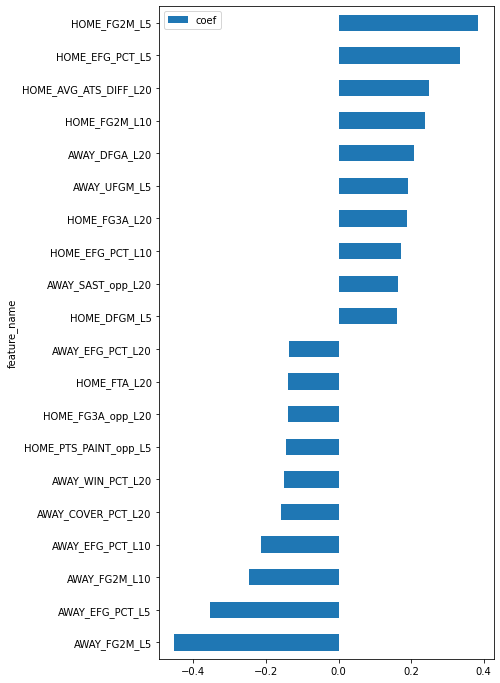

In [67]:
study_name = '../models/hyperparameter_tuning/study_logistic_regression'
storage_name = "sqlite:///{}.db".format(study_name)

study_lr = optuna.load_study(study_name=study_name, storage=storage_name)

lr_C = study_lr.best_params['C']
lr_l1_ratio = study_lr.best_params['l1_ratio']
print(lr_C)

best_lr = Pipeline([('scaler', StandardScaler()),
                    ('logreg', LogisticRegression(solver='saga', C=lr_C,
                                                  penalty='l2', max_iter=100000,
                                                 verbose=1, l1_ratio = lr_l1_ratio,
                                                 random_state=23))])
best_lr.fit(X_train, y_train)

print(best_lr)

print("train_acc:", best_lr.score(X_train, y_train))
print("test_acc:", best_lr.score(X_val, y_val))

view_model_coefs(best_lr.named_steps['logreg'], X_train)

In [68]:
tscv = TimeSeriesSplit(5)

lr_pipe = Pipeline(steps=[('scaler', StandardScaler()),
                ('logreg',
                 LogisticRegression(C=0.031670842561214795,
                                    l1_ratio=0.6782125608588861,
                                    penalty = 'elasticnet',
                                    max_iter=100000, random_state=23,
                                    solver='saga'))])

selector = RFECV(estimator = lr_pipe, step=10, cv=tscv, scoring='accuracy', importance_getter='named_steps.logreg.coef_', verbose=1)

selector = selector.fit(X_train, y_train)

Fitting estimator with 626 features.
Fitting estimator with 616 features.
Fitting estimator with 606 features.
Fitting estimator with 596 features.
Fitting estimator with 586 features.
Fitting estimator with 576 features.
Fitting estimator with 566 features.
Fitting estimator with 556 features.
Fitting estimator with 546 features.
Fitting estimator with 536 features.
Fitting estimator with 526 features.
Fitting estimator with 516 features.
Fitting estimator with 506 features.
Fitting estimator with 496 features.
Fitting estimator with 486 features.
Fitting estimator with 476 features.
Fitting estimator with 466 features.
Fitting estimator with 456 features.
Fitting estimator with 446 features.
Fitting estimator with 436 features.
Fitting estimator with 426 features.
Fitting estimator with 416 features.
Fitting estimator with 406 features.
Fitting estimator with 396 features.
Fitting estimator with 386 features.
Fitting estimator with 376 features.
Fitting estimator with 366 features.
F

In [ ]:
tscv = TimeSeriesSplit(5)

lr_pipe = Pipeline(steps=[('scaler', StandardScaler()),
                ('logreg',
                 LogisticRegression(C=0.031670842561214795,
                                    l1_ratio=0.6782125608588861,
                                    penalty = 'elasticnet',
                                    max_iter=100000, random_state=23,
                                    solver='saga'))])

selector = RFE(estimator = lr_pipe, n_features_to_select=285, step=2, importance_getter='named_steps.logreg.coef_', verbose=1)

selector = selector.fit(X_train, y_train)

Fitting estimator with 627 features.
Fitting estimator with 625 features.
Fitting estimator with 623 features.
Fitting estimator with 621 features.
Fitting estimator with 619 features.
Fitting estimator with 617 features.
Fitting estimator with 615 features.
Fitting estimator with 613 features.
Fitting estimator with 611 features.
Fitting estimator with 609 features.
Fitting estimator with 607 features.
Fitting estimator with 605 features.
Fitting estimator with 603 features.
Fitting estimator with 601 features.
Fitting estimator with 599 features.
Fitting estimator with 597 features.
Fitting estimator with 595 features.
Fitting estimator with 593 features.
Fitting estimator with 591 features.
Fitting estimator with 589 features.
Fitting estimator with 587 features.
Fitting estimator with 585 features.
Fitting estimator with 583 features.
Fitting estimator with 581 features.
Fitting estimator with 579 features.
Fitting estimator with 577 features.
Fitting estimator with 575 features.
F

In [69]:
pd.DataFrame(X_train.iloc[:, selector.support_].columns, columns=['features']).to_csv('linear_regression_RFE_selected_features_no_ML.csv', index=False)

In [70]:
# X_train.iloc[:, selector.support_]

features = pd.read_csv('linear_regression_RFE_selected_features_no_ML.csv')
features = features['features'].tolist()


X_train_selected = X_train[features]
X_val_selected = X_val[features]
X_test_selected = X_test[features]

## Logistic Regression (ElasticNet Penalty) With RFE Feature Selection

In [71]:
def objective(trial):
    
    lr_C = trial.suggest_float('C', 1e-5, 1e2, log=True)
    lr_l1_ratio = trial.suggest_float('l1_ratio', 0, 1, log=False)
    
    classifier_obj = Pipeline([('scaler', StandardScaler()),
                                ('logreg', LogisticRegression(solver='saga',
                                                              C=lr_C,
                                                            penalty='elasticnet',
                                                            max_iter=10000,
                                                            verbose=1,
                                                            l1_ratio=lr_l1_ratio,
                                                            random_state=23))])
    
    score = cross_val_score(classifier_obj, X_train_selected, y_train, n_jobs=-1,
                           cv=tscv, scoring='accuracy')
    
    
    score_avg = score.mean()
    
    return score_avg

study_name = '../models/hyperparameter_tuning/study_logistic_regression_rfe_no_ML'
storage_name = "sqlite:///{}.db".format(study_name)

study_lr = optuna.create_study(study_name = study_name, direction='maximize', 
                               storage = storage_name, load_if_exists=True)

study_lr.optimize(objective, n_trials=300)

[I 2022-10-08 19:07:02,424] A new study created in RDB with name: ../models/hyperparameter_tuning/study_logistic_regression_rfe_no_ML
[I 2022-10-08 19:07:05,879] Trial 0 finished with value: 0.713917940466613 and parameters: {'C': 1.1614848311770705, 'l1_ratio': 0.827808118422565}. Best is trial 0 with value: 0.713917940466613.
[I 2022-10-08 19:07:06,255] Trial 1 finished with value: 0.614320193081255 and parameters: {'C': 0.0007398504043236131, 'l1_ratio': 0.24959907463888398}. Best is trial 0 with value: 0.713917940466613.
[I 2022-10-08 19:07:07,038] Trial 2 finished with value: 0.7148833467417537 and parameters: {'C': 0.10477986047800653, 'l1_ratio': 0.6202928166261896}. Best is trial 2 with value: 0.7148833467417537.
[I 2022-10-08 19:07:09,034] Trial 3 finished with value: 0.7150442477876106 and parameters: {'C': 23.97081333197668, 'l1_ratio': 0.3079467619421281}. Best is trial 3 with value: 0.7150442477876106.
[I 2022-10-08 19:07:09,349] Trial 4 finished with value: 0.588897827835

0.27677434769738374 0.06855329257415738


c:\Users\Jordan Nishimura\NBA_Model_v1\nba-model-venv\lib\site-packages\sklearn\linear_model\_logistic.py:1106: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 43 epochs took 0 seconds
Pipeline(steps=[('scaler', StandardScaler()),
                ('logreg',
                 LogisticRegression(C=0.27677434769738374,
                                    l1_ratio=0.06855329257415738,
                                    max_iter=10000, random_state=23,
                                    solver='saga', verbose=1))])
train_acc: 0.7264682220434433
test_acc: 0.6743261157755193


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished


,feature_name,coef
29,AWAY_EFG_PCT_L5,-0.647334
20,AWAY_FG2M_L5,-0.548273
7,HOME_TS_PCT_L5,-0.375517
2,HOME_AST_2PM_L5,-0.273866
3,HOME_UAST_2PM_L5,-0.260442
30,AWAY_FG3A_L10,-0.254344
15,HOME_PLUS_MINUS_opp_L20,-0.203113
44,AWAY_EFG_PCT_L20,-0.200242
42,AWAY_WIN_PCT_L20,-0.151859
6,HOME_UFGA_opp_L5,-0.150051


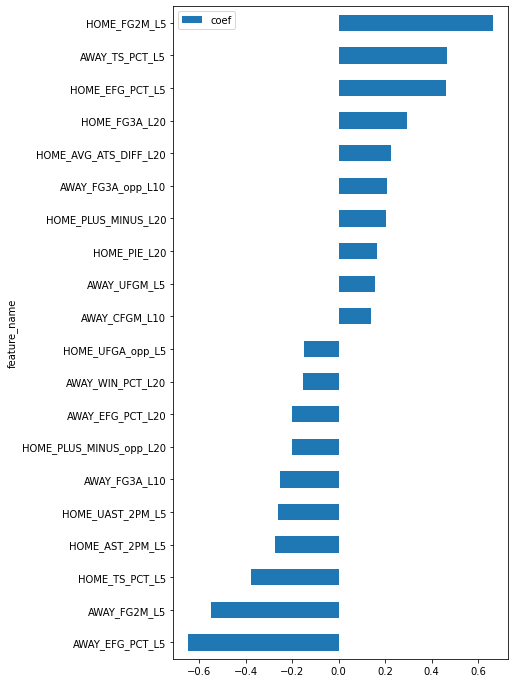

In [72]:
lr_C = study_lr.best_params['C']
lr_l1_ratio = study_lr.best_params['l1_ratio']
print(lr_C, lr_l1_ratio)

best_lr = Pipeline([('scaler', StandardScaler()),
                    ('logreg', LogisticRegression(solver='saga', C=lr_C,
                                                  penalty='l2', max_iter=10000,
                                                 verbose=1, l1_ratio = lr_l1_ratio,
                                                 random_state=23))])
best_lr.fit(X_train_selected, y_train)

print(best_lr)

print("train_acc:", best_lr.score(X_train_selected, y_train))
print("test_acc:", best_lr.score(X_val_selected, y_val))

view_model_coefs(best_lr.named_steps['logreg'], X_train_selected)

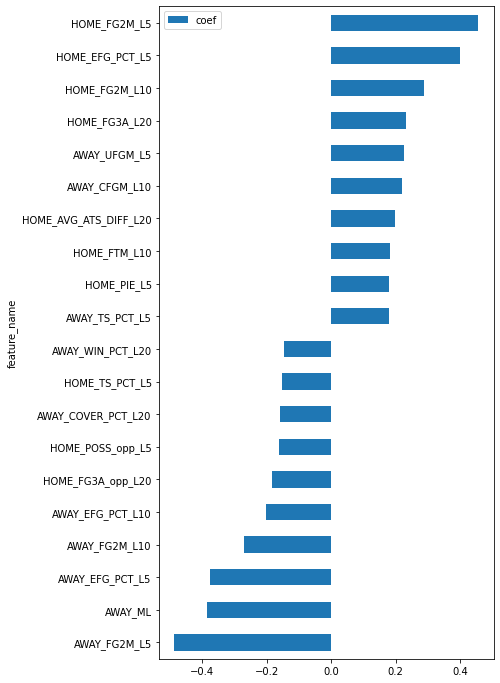

In [21]:
logreg_coefs = view_model_coefs(best_lr.named_steps['logreg'], X_train_selected)

In [29]:
logreg_coefs.sort_values('coef', ascending=False).head(40)



,feature_name,coef
0,HOME_FG2M_L5,0.456023
97,HOME_EFG_PCT_L5,0.400654
104,HOME_FG2M_L10,0.287717
127,HOME_FG3A_L20,0.231590
150,AWAY_UFGM_L5,0.224497
209,AWAY_CFGM_L10,0.218000
137,HOME_AVG_ATS_DIFF_L20,0.197018
108,HOME_FTM_L10,0.183294
103,HOME_PIE_L5,0.179191
176,AWAY_TS_PCT_L5,0.179065


In [73]:
tscv = TimeSeriesSplit(5)

lgbc = lgb.LGBMClassifier(colsample_bytree=0.725714617307935,
               learning_rate=0.03366464571120959, max_depth=5,
               min_child_weight=0.534047514075973, num_leaves=194,
               reg_alpha=4.741561203592908, reg_lambda=5.4130017942167665,
               subsample=0.6316705486384242)

selector = RFECV(estimator = lgbc, step=5, cv=tscv, scoring='accuracy', verbose=1)

selector = selector.fit(X_train, y_train)

Fitting estimator with 626 features.
Fitting estimator with 621 features.
Fitting estimator with 616 features.
Fitting estimator with 611 features.
Fitting estimator with 606 features.
Fitting estimator with 601 features.
Fitting estimator with 596 features.
Fitting estimator with 591 features.
Fitting estimator with 586 features.
Fitting estimator with 581 features.
Fitting estimator with 576 features.
Fitting estimator with 571 features.
Fitting estimator with 566 features.
Fitting estimator with 561 features.
Fitting estimator with 556 features.
Fitting estimator with 551 features.
Fitting estimator with 546 features.
Fitting estimator with 541 features.
Fitting estimator with 536 features.
Fitting estimator with 531 features.
Fitting estimator with 526 features.
Fitting estimator with 521 features.
Fitting estimator with 516 features.
Fitting estimator with 511 features.
Fitting estimator with 506 features.
Fitting estimator with 501 features.
Fitting estimator with 496 features.
F

In [74]:
pd.DataFrame(X_train.iloc[:, selector.support_].columns, columns=['features']).to_csv('LGBC_RFE_selected_features_no_ML.csv', index=False)

lgbc_features = pd.read_csv('LGBC_RFE_selected_features_no_ML.csv')
lgbc_features = lgbc_features['features'].tolist()
len(lgbc_features)

346

In [75]:
selected_cols = lgbc_features

def objective(trial):    
    min_child_weight = trial.suggest_float('min_child_weight', 1e-4, 1.0)
    subsample = trial.suggest_float('subsample', 0.6, 1)
    max_depth = trial.suggest_int('max_depth', 3, 32)
    reg_lambda = trial.suggest_float('reg_lambda', 1, 10)
    reg_alpha = trial.suggest_float('reg_alpha', 0, 5),
    num_leaves = trial.suggest_int('num_leaves', 2, 512)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.1, 1.0)
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1.0, log=True)
    
    classifier_obj = Pipeline(steps=[("selector", ColumnTransformer([
        ("selector", "passthrough", selected_cols)], remainder="drop")),
        ('lgbc', lgb.LGBMClassifier(colsample_bytree=colsample_bytree,
               learning_rate=learning_rate, max_depth=max_depth,
               min_child_weight=min_child_weight, num_leaves=num_leaves,
               random_state=23, reg_alpha=reg_alpha,
               reg_lambda=reg_lambda, subsample=subsample))])
    
    score = cross_val_score(classifier_obj, X_train, y_train, n_jobs=-1,
                           cv=tscv, scoring='accuracy')
    
    
    score_avg = score.mean()
    
    return score_avg

study_name = '../models/hyperparameter_tuning/study_lgbc_selected'
storage_name = "sqlite:///{}.db".format(study_name)

study_lgbc = optuna.create_study(study_name = study_name, direction='maximize', 
                               storage = storage_name, load_if_exists=True)

study_lgbc.optimize(objective, n_trials=300)

[I 2022-10-08 19:25:42,398] Using an existing study with name '../models/hyperparameter_tuning/study_lgbc_selected' instead of creating a new one.
[I 2022-10-08 19:25:50,538] Trial 400 finished with value: 0.6727272727272727 and parameters: {'min_child_weight': 0.36083198921897236, 'subsample': 0.7570934873921117, 'max_depth': 8, 'reg_lambda': 3.08308667205839, 'reg_alpha': 0.40163963017114057, 'num_leaves': 12, 'colsample_bytree': 0.8577160800881948, 'learning_rate': 0.22371344396773096}. Best is trial 304 with value: 0.7036202735317779.
[I 2022-10-08 19:25:57,131] Trial 401 finished with value: 0.6651649235720032 and parameters: {'min_child_weight': 0.19408251334049284, 'subsample': 0.6941906168816298, 'max_depth': 5, 'reg_lambda': 5.479762014730576, 'reg_alpha': 0.14656965809126715, 'num_leaves': 23, 'colsample_bytree': 0.8297535268032742, 'learning_rate': 0.3289348803842107}. Best is trial 304 with value: 0.7036202735317779.
[I 2022-10-08 19:25:59,139] Trial 402 finished with value

train_acc: 0.7064896755162242
val_acc: 0.6522315510384445
test_acc: 0.6620745542949756
LGBoost or XGBoost


,feature_name,coef
178,AWAY_OREB_L5,1
337,AWAY_TS_PCT_opp_L20,1
334,AWAY_COVER_PCT_L20,1
332,AWAY_AVG_ATS_DIFF_L20,1
320,AWAY_NET_RATING_opp_L20,1
317,AWAY_PF_opp_L20,1
308,AWAY_UAST_2PM_L20,1
304,AWAY_DFGA_L20,1
284,AWAY_FG3A_L20,1
283,AWAY_FG3M_L20,1


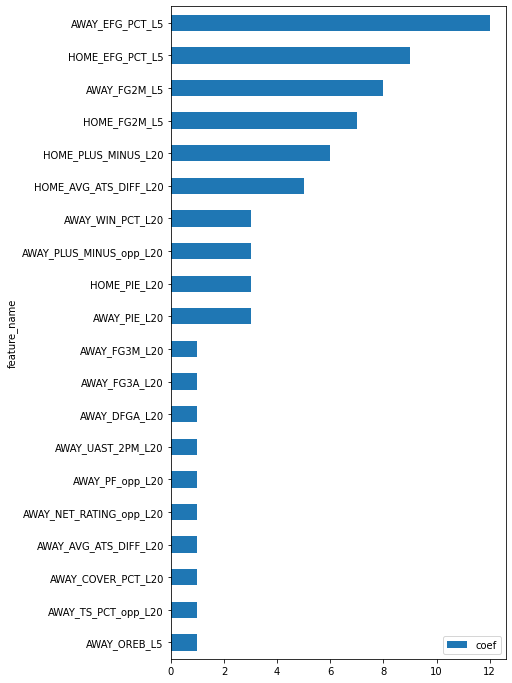

In [77]:
params = study_lgbc.best_params

best_lgbc = Pipeline(steps=[("selector", ColumnTransformer([
        ("selector", "passthrough", selected_cols)], remainder="drop")),
        ('lgbc', lgb.LGBMClassifier(**params))])

best_lgbc.fit(X_train, y_train)

print("train_acc:", best_lgbc.score(X_train, y_train))
print("val_acc:", best_lgbc.score(X_val, y_val))
print("test_acc:", best_lgbc.score(X_test, y_test))


view_model_coefs(best_lgbc.named_steps['lgbc'], X_train[selected_cols])

In [40]:
best_lgbc

LGBMClassifier(colsample_bytree=0.725714617307935,
               learning_rate=0.03366464571120959, max_depth=5,
               min_child_weight=0.534047514075973, num_leaves=194,
               reg_alpha=4.741561203592908, reg_lambda=5.4130017942167665,
               subsample=0.6316705486384242)

## LGBClassifier No Feature Selection

In [38]:
features = pd.read_csv('linear_regression_RFE_selected_features.csv')
selected_cols = features['features'].tolist()

def objective(trial):    
    min_child_weight = trial.suggest_float('min_child_weight', 1e-4, 1.0)
    subsample = trial.suggest_float('subsample', 0.6, 1)
    max_depth = trial.suggest_int('max_depth', 3, 32)
    reg_lambda = trial.suggest_float('reg_lambda', 1, 10)
    reg_alpha = trial.suggest_float('reg_alpha', 0, 5),
    num_leaves = trial.suggest_int('num_leaves', 2, 512)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.1, 1.0)
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1.0, log=True)
    
    classifier_obj = lgb.LGBMClassifier(colsample_bytree=colsample_bytree,
               learning_rate=learning_rate, max_depth=max_depth,
               min_child_weight=min_child_weight, num_leaves=num_leaves,
               random_state=23, reg_alpha=reg_alpha,
               reg_lambda=reg_lambda, subsample=subsample)
    
    score = cross_val_score(classifier_obj, X_train, y_train, n_jobs=-1,
                           cv=tscv, scoring='accuracy')
    
    
    score_avg = score.mean()
    
    return score_avg

study_name = '../models/hyperparameter_tuning/study_lgbc'
storage_name = "sqlite:///{}.db".format(study_name)

study_lgbc = optuna.create_study(study_name = study_name, direction='maximize', 
                               storage = storage_name, load_if_exists=True)

study_lgbc.optimize(objective, n_trials=200)

[I 2022-10-08 11:28:42,850] A new study created in RDB with name: ../models/hyperparameter_tuning/study_lgbc
[I 2022-10-08 11:29:11,404] Trial 0 finished with value: 0.588897827835881 and parameters: {'min_child_weight': 0.7945820844069986, 'subsample': 0.867006029374243, 'max_depth': 31, 'reg_lambda': 1.002477454176816, 'reg_alpha': 3.754182600915853, 'num_leaves': 251, 'colsample_bytree': 0.8443812917531429, 'learning_rate': 0.00019335906781807813}. Best is trial 0 with value: 0.588897827835881.
[I 2022-10-08 11:29:20,649] Trial 1 finished with value: 0.5990345937248593 and parameters: {'min_child_weight': 0.7004950986100416, 'subsample': 0.7368655428306523, 'max_depth': 14, 'reg_lambda': 6.617448837534741, 'reg_alpha': 0.386326348857049, 'num_leaves': 238, 'colsample_bytree': 0.22604027835477142, 'learning_rate': 0.0028727704948619506}. Best is trial 1 with value: 0.5990345937248593.
[I 2022-10-08 11:29:33,979] Trial 2 finished with value: 0.6212389380530974 and parameters: {'min_ch

train_acc: 0.7842585143470099
val_acc: 0.6646045072912063
LGBoost or XGBoost


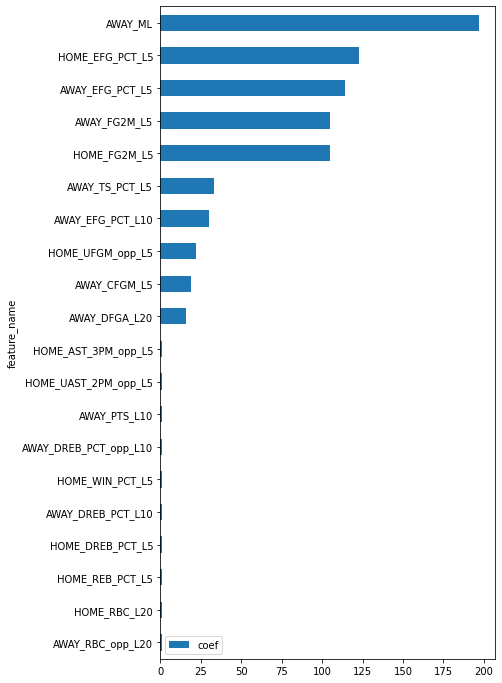

In [39]:
study_name = '../models/hyperparameter_tuning/study_lgbc'
storage_name = "sqlite:///{}.db".format(study_name)

study_lgbc = optuna.load_study(study_name = study_name, storage = storage_name)

params = study_lgbc.best_params

best_lgbc =  lgb.LGBMClassifier(**params)

best_lgbc.fit(X_train, y_train)

print("train_acc:", best_lgbc.score(X_train, y_train))
print("val_acc:", best_lgbc.score(X_val, y_val))

lgbc_features = view_model_coefs(best_lgbc, X_train)

In [55]:
sorted(X_train.columns.tolist())

['AWAY_AST_2PM_L10',
 'AWAY_AST_2PM_L20',
 'AWAY_AST_2PM_L5',
 'AWAY_AST_2PM_opp_L10',
 'AWAY_AST_2PM_opp_L20',
 'AWAY_AST_2PM_opp_L5',
 'AWAY_AST_3PM_L10',
 'AWAY_AST_3PM_L20',
 'AWAY_AST_3PM_L5',
 'AWAY_AST_3PM_opp_L10',
 'AWAY_AST_3PM_opp_L20',
 'AWAY_AST_3PM_opp_L5',
 'AWAY_AST_L10',
 'AWAY_AST_L20',
 'AWAY_AST_L5',
 'AWAY_AST_RATIO_L10',
 'AWAY_AST_RATIO_L20',
 'AWAY_AST_RATIO_L5',
 'AWAY_AST_RATIO_opp_L10',
 'AWAY_AST_RATIO_opp_L20',
 'AWAY_AST_RATIO_opp_L5',
 'AWAY_AST_opp_L10',
 'AWAY_AST_opp_L20',
 'AWAY_AST_opp_L5',
 'AWAY_AVG_ATS_DIFF_L10',
 'AWAY_AVG_ATS_DIFF_L20',
 'AWAY_AVG_ATS_DIFF_L5',
 'AWAY_BLK_L10',
 'AWAY_BLK_L20',
 'AWAY_BLK_L5',
 'AWAY_BLK_opp_L10',
 'AWAY_BLK_opp_L20',
 'AWAY_BLK_opp_L5',
 'AWAY_CFGA_L10',
 'AWAY_CFGA_L20',
 'AWAY_CFGA_L5',
 'AWAY_CFGA_opp_L10',
 'AWAY_CFGA_opp_L20',
 'AWAY_CFGA_opp_L5',
 'AWAY_CFGM_L10',
 'AWAY_CFGM_L20',
 'AWAY_CFGM_L5',
 'AWAY_CFGM_opp_L10',
 'AWAY_CFGM_opp_L20',
 'AWAY_CFGM_opp_L5',
 'AWAY_COVER_PCT_L10',
 'AWAY_COVER_PCT_L20

In [ ]:
res = pd.DataFrame.from_dict(sfs_pipe.named_steps['sffs'].get_metric_dict()).T
res.sort_values('avg_score', ascending=False)

best_trial = res.sort_values('avg_score', ascending=False).index[0]

feature_idx = [int(x) for x in res.loc[best_trial, 'feature_names']]
sfs_selected_cols_sgd_log = X_train.iloc[:, feature_idx].columns
sfs_selected_cols_sgd_log

In [ ]:
res = pd.DataFrame.from_dict(sfs_pipe.named_steps['sfs'].get_metric_dict()).T
res.sort_values('avg_score', ascending=False)

best_trial = res.sort_values('avg_score', ascending=False).index[0]

feature_idx = [int(x) for x in res.loc[best_trial, 'feature_names']]
sfs_selected_cols_sgd_log = X_train.iloc[:, feature_idx].columns
sfs_selected_cols_sgd_log

In [ ]:
sfs_pipe_lr = Pipeline([('scaler', StandardScaler()),
                     ('sfs', SFS(LogisticRegression(solver='saga',tol = 0.001, max_iter=1000, n_jobs=-1, random_state=23),
                        k_features='best', cv=tscv, scoring='accuracy', verbose=2))])


sfs_pipe_lr.fit(X_train, y_train)



In [ ]:
res = pd.DataFrame.from_dict(sfs_pipe_lr.named_steps['sfs'].get_metric_dict()).T
res.sort_values('avg_score', ascending=False)

best_trial = res.sort_values('avg_score', ascending=False).index[0]

feature_idx = [int(x) for x in res.loc[best_trial, 'feature_names']]
sfs_selected_cols_log = X_train.iloc[:, feature_idx].columns
sfs_selected_cols_log

In [ ]:
sfs = SequentialFeatureSelector(lr, scoring = 'accuracy', cv=tscv, n_jobs=-1)

sfs.fit(rfe_features, y_train)

In [ ]:
selected_cols = rfe_features.iloc[:, sfs.support_].columns

In [ ]:
lr.fit(X_train[selected_cols], y_train)

print(lr.score(X_test[selected_cols], y_test))

In [ ]:

view_model_coefs(lr.named_steps['lr'], X_train[selected_cols])

## Training Models

### Logistic Regression

Train Set: 2006-2015
<br>Test Set: 2016-2020

In [ ]:
sfs_selected_cols_log = ['RECORD_team_diff', 'OREB_team_diff', 'DREB_team_diff', 'REB_team_diff',
       'STL_team_diff', 'TOV_team_diff', 'PLUS_MINUS_team_diff',
       'E_DEF_RATING_team_diff', 'PTS_OFF_TOV_team_diff', 'AST_3PM_team_diff',
       'UAST_2PM_team_diff', 'ATS_DIFF_team_diff', 'FG2A_opp_diff',
       'FG3A_opp_diff', 'FTM_opp_diff', 'FTA_opp_diff', 'AST_opp_diff',
       'TOV_opp_diff', 'E_OFF_RATING_opp_diff', 'PTS_FB_opp_diff',
       'AST_2PM_opp_diff', 'UAST_2PM_opp_diff', 'UAST_3PM_opp_diff',
       'ATS_PCT_diff', 'AVG_SPREAD_diff', 'AVG_ML_diff', 'AVG_ATS_DIFF_diff',
       'REST_diff', 'OREB_PCT_team_diff', 'OREB_PCT_opp_diff',
       'DREB_PCT_team_diff', 'DREB_PCT_opp_diff', 'TS_PCT_team_diff',
       'EFG_PCT_team_diff', 'EFG_PCT_opp_diff', 'AST_RATIO_team_diff',
       'TOV_PCT_team_diff', 'TOV_PCT_opp_diff', 'team_elo_pred',
       'elo_MOV_pred', 'SPREAD_team']

In [ ]:
def objective(trial):
    
    lr_C = trial.suggest_float('C', 1e-5, 1e2, log=True)
    
    classifier_obj = Pipeline([('selector', ColumnTransformer([
                        ("selector", "passthrough", sfs_selected_cols_log)
                    ], remainder="drop")),
                                        ('scaler', StandardScaler()),
                                        ('logreg', LogisticRegression(solver='saga', C=lr_C,
                                                                      penalty='l2', max_iter=10000,
                                                                     verbose=1, random_state=23))])
    
    score = cross_val_score(classifier_obj, X_train, y_train, n_jobs=-1,
                           cv=tscv, scoring='accuracy')
    
    
    score_avg = score.mean()
    
    return score_avg

study_name = '../models/hyperparameter_tuning/study_lr2_select_sffs'
storage_name = "sqlite:///{}.db".format(study_name)

study_lr = optuna.create_study(study_name = study_name, direction='maximize', 
                               storage = storage_name, load_if_exists=True)

study_lr.optimize(objective, n_trials=1)

In [ ]:
study_lr.trials_dataframe().sort_values(['value'])

In [ ]:
lr_C = study_lr.best_params['C']
print(lr_C)
best_lr = Pipeline([('selector', ColumnTransformer([
    ("selector", "passthrough", sfs_selected_cols_log)
], remainder="drop")),
                    ('scaler', StandardScaler()),
                    ('logreg', LogisticRegression(solver='saga', C=lr_C,
                                                  penalty='l2', max_iter=100000,
                                                 verbose=1, random_state=23))])
best_lr.fit(X_train, y_train)

print(best_lr)

print("train_acc:", best_lr.score(X_train, y_train))
print("test_acc:", best_lr.score(X_test, y_test))

view_model_coefs(best_lr.named_steps['logreg'], X_train[sfs_selected_cols_log])

In [ ]:
filename = '../models/best_lr_diffs_sfs'
joblib.dump(best_lr, filename)

### SGD Hinge (SVC Linear)

In [ ]:
sfs_pipe_sgd = Pipeline([('scaler', StandardScaler()),
                     ('sffs', SFS(SGDClassifier(loss='hinge', random_state=23, alpha=0.03320641664870966),
                        k_features='best', cv=tscv, scoring='accuracy', floating=True, verbose=1))])


sfs_pipe_sgd.fit(X_train, y_train)

In [ ]:
res = pd.DataFrame.from_dict(sfs_pipe_sgd.named_steps['sffs'].get_metric_dict()).T
res.sort_values('avg_score', ascending=False)

best_trial = res.sort_values('avg_score', ascending=False).index[0]

feature_idx = [int(x) for x in res.loc[best_trial, 'feature_names']]
sfs_selected_cols_hinge = X_train.iloc[:, feature_idx].columns
sfs_selected_cols_hinge

In [ ]:
res = pd.DataFrame.from_dict(sfs_pipe_sgd.named_steps['sfs'].get_metric_dict()).T
res.sort_values('avg_score', ascending=False)

best_trial = res.sort_values('avg_score', ascending=False).index[0]

feature_idx = [int(x) for x in res.loc[best_trial, 'feature_names']]
sfs_selected_cols_hinge = X_train.iloc[:, feature_idx].columns
sfs_selected_cols_hinge

In [ ]:
sfs_selected_cols_hinge = ['RECORD_team_diff', 'FG2M_team_diff', 'FG3M_team_diff',
       'FG3A_team_diff', 'FTM_team_diff', 'FTA_team_diff', 'OREB_team_diff',
       'DREB_team_diff', 'REB_team_diff', 'AST_team_diff', 'STL_team_diff',
       'PTS_team_diff', 'PLUS_MINUS_team_diff', 'E_OFF_RATING_team_diff',
       'E_NET_RATING_team_diff', 'POSS_team_diff', 'PIE_team_diff',
       'PTS_OFF_TOV_team_diff', 'AST_2PM_team_diff', 'AST_3PM_team_diff',
       'UAST_2PM_team_diff', 'UAST_3PM_team_diff', 'RECORD_opp_diff',
       'FG2M_opp_diff', 'FG2A_opp_diff', 'FG3A_opp_diff', 'FTM_opp_diff',
       'FTA_opp_diff', 'OREB_opp_diff', 'TOV_opp_diff', 'PF_opp_diff',
       'PTS_opp_diff', 'PLUS_MINUS_opp_diff', 'E_DEF_RATING_opp_diff',
       'E_NET_RATING_opp_diff', 'PIE_opp_diff', 'PTS_FB_opp_diff',
       'AST_2PM_opp_diff', 'UAST_2PM_opp_diff', 'UAST_3PM_opp_diff',
       'WL_PCT_diff', 'REST_diff', 'OREB_PCT_team_diff', 'OREB_PCT_opp_diff',
       'DREB_PCT_team_diff', 'TS_PCT_team_diff', 'EFG_PCT_team_diff',
       'EFG_PCT_opp_diff', 'AST_RATIO_team_diff', 'AST_RATIO_opp_diff',
       'TOV_PCT_opp_diff', 'elo_MOV_pred', 'SPREAD_team']

In [ ]:
def objective(trial):
    sgd_alpha = trial.suggest_float('alpha', 1e-5, 1e2, log=True)
    
    classifier_obj = Pipeline(steps=[("selector", ColumnTransformer([
        ("selector", "passthrough", sfs_selected_cols_hinge)], remainder="drop")),
        ('scaler', StandardScaler()),
                ('sgd', SGDClassifier(alpha = sgd_alpha,
                                      loss='hinge',
                                       max_iter=5000,
                                     random_state=23))])
    
    score = cross_val_score(classifier_obj, X_train, y_train, n_jobs=-1,
                           cv=tscv, scoring='accuracy')
    
    
    score_avg = score.mean()
    
    return score_avg

study_name = '../models/hyperparameter_tuning/study_sgd_hinge_sffs'
storage_name = "sqlite:///{}.db".format(study_name)

study_sgd = optuna.create_study(study_name = study_name, direction='maximize', 
                               storage = storage_name, load_if_exists=True)

study_sgd.optimize(objective, n_trials=10, show_progress_bar=True)

In [ ]:
sgd_alpha = study_sgd.best_params['alpha']
print('C:', sgd_alpha)

best_sgd_hinge = Pipeline(steps=[("selector", ColumnTransformer([
        ("selector", "passthrough", sfs_selected_cols_hinge)], remainder="drop")),
        ('scaler', StandardScaler()),
                ('sgd', SGDClassifier(alpha = sgd_alpha,
                                      loss='hinge',
                                       max_iter=1000,
                                     random_state=23))])


best_sgd_hinge.fit(X_train, y_train)

print("best_svc:", best_sgd_hinge)


print("train_score:", best_sgd_hinge.score(X_train, y_train))
print("test_score:", best_sgd_hinge.score(X_test, y_test))

In [ ]:
filename = '../models/best_sgd_hinge_diffs_sfs'
joblib.dump(best_lr, filename)

### SGD modified_huber

In [ ]:
sfs_pipe_sgd_huber = Pipeline([('scaler', StandardScaler()),
                     ('sffs', SFS(SGDClassifier(loss='modified_huber', random_state=23, alpha=0.56299),
                        k_features='best', cv=tscv, scoring='accuracy', floating=True, verbose=1))])


sfs_pipe_sgd_huber.fit(X_train, y_train)

In [ ]:
res = pd.DataFrame.from_dict(sfs_pipe_sgd_huber.named_steps['sffs'].get_metric_dict()).T
res.sort_values('avg_score', ascending=False)

best_trial = res.sort_values('avg_score', ascending=False).index[0]

feature_idx = [int(x) for x in res.loc[best_trial, 'feature_names']]
sfs_selected_cols_huber = X_train.iloc[:, feature_idx].columns
sfs_selected_cols_huber

In [ ]:
res = pd.DataFrame.from_dict(sfs_pipe_sgd_huber.named_steps['sfs'].get_metric_dict()).T
res.sort_values('avg_score', ascending=False)

best_trial = res.sort_values('avg_score', ascending=False).index[0]

feature_idx = [int(x) for x in res.loc[best_trial, 'feature_names']]
sfs_selected_cols_huber = X_train.iloc[:, feature_idx].columns
sfs_selected_cols_huber

In [ ]:
sfs_selected_cols_huber = ['RECORD_team_diff', 'FG2M_team_diff', 'FG2A_team_diff',
       'FG3A_team_diff', 'FTM_team_diff', 'FTA_team_diff', 'OREB_team_diff',
       'DREB_team_diff', 'STL_team_diff', 'E_OFF_RATING_team_diff',
       'E_DEF_RATING_team_diff', 'PIE_team_diff', 'PTS_OFF_TOV_team_diff',
       'AST_2PM_team_diff', 'AST_3PM_team_diff', 'UAST_2PM_team_diff',
       'UAST_3PM_team_diff', 'RECORD_opp_diff', 'FG2M_opp_diff',
       'FG3A_opp_diff', 'FTA_opp_diff', 'AST_opp_diff',
       'E_OFF_RATING_opp_diff', 'E_DEF_RATING_opp_diff', 'PTS_FB_opp_diff',
       'AST_3PM_opp_diff', 'UAST_2PM_opp_diff', 'TEAM_COVERED_opp_diff',
       'WL_PCT_diff', 'REST_diff', 'TS_PCT_team_diff', 'AST_RATIO_team_diff',
       'AST_RATIO_opp_diff', 'TOV_PCT_opp_diff', 'ML_team']

In [ ]:
def objective(trial):
    sgd_alpha = trial.suggest_float('alpha', 1e-5, 1e2, log=True)
    
    classifier_obj = Pipeline(steps=[("selector", ColumnTransformer([
        ("selector", "passthrough", sfs_selected_cols_huber)], remainder="drop")),
        ('scaler', StandardScaler()),
                ('sgd', SGDClassifier(alpha = sgd_alpha,
                                      loss='modified_huber',
                                       max_iter=1000,
                                     random_state=23))])
    
    score = cross_val_score(classifier_obj, X_train, y_train, n_jobs=-1,
                           cv=tscv, scoring='accuracy')
    
    
    score_avg = score.mean()
    
    return score_avg

study_name = '../models/hyperparameter_tuning/study_sgd_huber_sffs'
storage_name = "sqlite:///{}.db".format(study_name)

study_sgd = optuna.create_study(study_name = study_name, direction='maximize', 
                               storage = storage_name, load_if_exists=True)

study_sgd.optimize(objective, n_trials=10, show_progress_bar = True)

In [ ]:
sgd_alpha = study_sgd.best_params['alpha']
print(sgd_alpha)
best_sgd_huber = Pipeline(steps=[("selector", ColumnTransformer([
        ("selector", "passthrough", sfs_selected_cols_huber)], remainder="drop")),
        ('scaler', StandardScaler()),
                ('sgd', SGDClassifier(alpha = sgd_alpha,
                                      loss='modified_huber',
                                       max_iter=1000,
                                     random_state=23))])

print("best_sgd:", best_sgd_huber)

best_sgd_huber.fit(X_train, y_train)

print("train_score:", best_sgd_huber.score(X_train, y_train))
print("test_score:", best_sgd_huber.score(X_test, y_test))

view_model_coefs(best_sgd_huber.named_steps['sgd'], X_train[sfs_selected_cols_huber])

In [ ]:
filename = '../models/best_sgd_huber_diffs_sfs'

joblib.dump(best_sgd_huber, filename)

### LGBClassifier

In [ ]:
sfs_pipe_lgb = Pipeline([('scaler', StandardScaler()),
                     ('sfs', SFS(lgb.LGBMClassifier(colsample_bytree=0.30306249172980904,
               learning_rate=0.03464725063611881, max_depth=3,
               min_child_weight=0.6782064406615411, num_leaves=120,
               random_state=23, reg_alpha=2.5908850696822157,
               reg_lambda=6.57863348422055, subsample=0.7226323380307508),
                        k_features='best', cv=tscv, scoring='accuracy', verbose=1))])


sfs_pipe_lgb.fit(X_train, y_train)

In [ ]:
res = pd.DataFrame.from_dict(sfs_pipe_lgb.named_steps['sfs'].get_metric_dict()).T
res.sort_values('avg_score', ascending=False)

best_trial = res.sort_values('avg_score', ascending=False).index[0]

feature_idx = [int(x) for x in res.loc[best_trial, 'feature_names']]
sfs_selected_cols_lgb = X_train.iloc[:, feature_idx].columns
sfs_selected_cols_lgb

In [ ]:
def objective(trial):    
    min_child_weight = trial.suggest_float('min_child_weight', 1e-4, 1.0)
    subsample = trial.suggest_float('subsample', 0.6, 1)
    max_depth = trial.suggest_int('max_depth', 3, 32)
    reg_lambda = trial.suggest_float('reg_lambda', 1, 10)
    reg_alpha = trial.suggest_float('reg_alpha', 0, 5),
    num_leaves = trial.suggest_int('num_leaves', 2, 512)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.1, 1.0)
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1.0, log=True)
    
    classifier_obj = Pipeline(steps=[("selector", ColumnTransformer([
        ("selector", "passthrough", sfs_selected_cols_lgb)], remainder="drop")),
        ('lgbc', lgb.LGBMClassifier(colsample_bytree=colsample_bytree,
               learning_rate=learning_rate, max_depth=max_depth,
               min_child_weight=min_child_weight, num_leaves=num_leaves,
               random_state=23, reg_alpha=reg_alpha,
               reg_lambda=reg_lambda, subsample=subsample))])
    
    score = cross_val_score(classifier_obj, X_train, y_train, n_jobs=-1,
                           cv=tscv, scoring='accuracy')
    
    
    score_avg = score.mean()
    
    return score_avg

study_name = '../models/hyperparameter_tuning/study_lgbc_sfs'
storage_name = "sqlite:///{}.db".format(study_name)

study_lgbc = optuna.create_study(study_name = study_name, direction='maximize', 
                               storage = storage_name, load_if_exists=True)

study_lgbc.optimize(objective, n_trials=200, show_progress_bar=True)

In [ ]:
import 

In [ ]:
def objective(trial):    
    min_child_weight = trial.suggest_float('min_child_weight', 1e-4, 1.0)
    subsample = trial.suggest_float('subsample', 0.6, 1)
    max_depth = trial.suggest_int('max_depth', 3, 32)
    reg_lambda = trial.suggest_float('reg_lambda', 1, 10)
    reg_alpha = trial.suggest_float('reg_alpha', 0, 5),
    num_leaves = trial.suggest_int('num_leaves', 2, 512)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.1, 1.0)
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1.0, log=True)
    
    classifier_obj = lgb.LGBMClassifier(colsample_bytree=colsample_bytree,
               learning_rate=learning_rate, max_depth=max_depth,
               min_child_weight=min_child_weight, num_leaves=num_leaves,
               random_state=23, reg_alpha=reg_alpha,
               reg_lambda=reg_lambda, subsample=subsample)
    
    score = cross_val_score(classifier_obj, X_train, y_train, n_jobs=-1,
                           cv=tscv, scoring='accuracy')
    
    
    score_avg = score.mean()
    
    return score_avg

study_name = '../models/hyperparameter_tuning/study_lgbc'
storage_name = "sqlite:///{}.db".format(study_name)

study_lgbc = optuna.create_study(study_name = study_name, direction='maximize', 
                               storage = storage_name, load_if_exists=True)

study_lgbc.optimize(objective, n_trials=100, show_progress_bar=True)

In [ ]:
study_name = '../models/hyperparameter_tuning/study_lgbc'
storage_name = "sqlite:///{}.db".format(study_name)

study_lgbc = optuna.load_study(study_name = study_name, storage = storage_name)

lgbc_params = study_lgbc.best_trial.params
lgbc_params['random_state'] = 23
best_lgbc = lgb.LGBMClassifier()
best_lgbc.set_params(**lgbc_params)
print("best_lgbc:", best_lgbc)

best_lgbc.fit(X_train, y_train)

print("train_acc:", best_lgbc.score(X_train, y_train))
print("test_acc:", best_lgbc.score(X_test, y_test))


view_model_coefs(best_lgbc, X_train)


In [ ]:
filename = '../models/best_lgbc_diffs'
joblib.dump(best_lgbc, filename)

In [ ]:
lgbc_params = study_lgbc.best_trial.params
lgbc_params['random_state'] = 23
best_lgbc = lgb.LGBMClassifier()
best_lgbc.set_params(**lgbc_params)
print("best_lgbc:", best_lgbc)

best_lgbc.fit(X_train, y_train)

print("train_acc:", best_lgbc.score(X_train, y_train))
print("test_acc:", best_lgbc.score(X_test, y_test))


view_model_coefs(best_lgbc, X_train)


In [ ]:
best_lgbc = lgb.LGBMClassifier(colsample_bytree=0.30306249172980904,
               learning_rate=0.03464725063611881, max_depth=3,
               min_child_weight=0.6782064406615411, num_leaves=120,
               random_state=23, reg_alpha=2.5908850696822157,
               reg_lambda=6.57863348422055, subsample=0.7226323380307508)

In [ ]:
from sklearn.decomposition import PCA


### KNNeighbors

In [ ]:
sfs_pipe_knn = Pipeline(steps=[('scaler', StandardScaler()),
                                     ('pca', PCA(n_components=0.99)),
                                    ('knn',
                                     SFS(KNeighborsClassifier(n_neighbors=47),
                                    k_features='best', cv=tscv, scoring='accuracy', verbose=1))])


sfs_pipe_knn.fit(X_train, y_train)




In [ ]:
res = pd.DataFrame.from_dict(sfs_pipe_knn.named_steps['knn'].get_metric_dict()).T
res.sort_values('avg_score', ascending=False)

best_trial = res.sort_values('avg_score', ascending=False).index[0]

feature_idx = [int(x) for x in res.loc[best_trial, 'feature_names']]
sfs_selected_cols_knn = X_train.iloc[:, feature_idx].columns
sfs_selected_cols_knn

In [ ]:
sfs_selected_cols_knn = ['FG2M_team_diff', 'FG2A_team_diff', 'FTM_team_diff', 'AST_team_diff',
       'BLK_team_diff', 'TOV_team_diff', 'PF_team_diff',
       'PLUS_MINUS_team_diff', 'E_OFF_RATING_team_diff', 'POSS_team_diff',
       'PIE_team_diff', 'PTS_2PT_MR_team_diff', 'PTS_OFF_TOV_team_diff',
       'AST_3PM_team_diff', 'UAST_2PM_team_diff', 'UAST_3PM_team_diff',
       'ATS_DIFF_team_diff', 'RECORD_opp_diff', 'FG2M_opp_diff',
       'FG3M_opp_diff', 'FG3A_opp_diff', 'FTM_opp_diff', 'FTA_opp_diff']

In [ ]:
def objective(trial):    

    n_neighbors = trial.suggest_int('n_neighbors', 1, 52)
    n_components = trial.suggest_float('n_components', 0.9, 0.99)
    
    classifier_obj = Pipeline(steps=[("selector", ColumnTransformer([
        ("selector", "passthrough", sfs_selected_cols_knn)], remainder="drop")),
        ('scaler', StandardScaler()),
        ('pca', PCA(n_components=n_components)),
                ('knn',
                 KNeighborsClassifier(n_neighbors=n_neighbors))])
    
    score = cross_val_score(classifier_obj, X_train, y_train, n_jobs=-1,
                           cv=tscv, scoring='accuracy')
    
    
    score_avg = score.mean()
    
    return score_avg

study_name = '../models/hyperparameter_tuning/study_knn_sfs'
storage_name = "sqlite:///{}.db".format(study_name)

search_space = {'n_neighbors':np.arange(3, 50, 4).tolist(),
               'n_components':np.linspace(0.9, 0.99, 10).tolist()}

study_knn = optuna.create_study(study_name = study_name, direction='maximize', 
                               storage = storage_name, load_if_exists=True,
                               sampler = optuna.samplers.GridSampler(search_space))

study_knn.optimize(objective)

In [ ]:
study_name = '../models/hyperparameter_tuning/study_knn_sfs'
storage_name = "sqlite:///{}.db".format(study_name)

study_knn = optuna.load_study(study_name = study_name, 
                               storage = storage_name)


best_n = study_knn.best_trial.params['n_neighbors']
best_n_components = study_knn.best_trial.params['n_components']


best_knn = Pipeline(steps=[("selector", ColumnTransformer([
        ("selector", "passthrough", sfs_selected_cols_knn)], remainder="drop")),
        ('scaler', StandardScaler()),
        ('pca', PCA(n_components=best_n_components)),
                ('knn',
                 KNeighborsClassifier(n_neighbors=best_n))])

print("best_knn:", best_knn)

best_knn.fit(X_train, y_train)

print("train_score:", best_knn.score(X_train, y_train))
print("test_score:", best_knn.score(X_test, y_test))

In [ ]:
filename = 'best_knn_diffs_sfs'

joblib.dump(best_knn, filename)

### Random Forest

In [ ]:
sfs_pipe_rf = SFS(RandomForestClassifier(max_depth=9,
                                        min_samples_leaf=0.010338564023847334,
                                        min_samples_split=0.017844890716741457,
                                        random_state=23), k_features=25, cv=tscv, scoring='accuracy', floating=True, verbose=1)


sfs_pipe_rf.fit(X_train, y_train)

In [ ]:
res = pd.DataFrame.from_dict(sfs_pipe_rf.get_metric_dict()).T
res.sort_values('avg_score', ascending=False)

best_trial = res.sort_values('avg_score', ascending=False).index[0]

sfs_selected_cols_rf = [str(x) for x in res.loc[best_trial, 'feature_names']]
# sfs_selected_cols_rf = X_train.iloc[:, feature_idx].columns
sfs_selected_cols_rf

In [ ]:
res = pd.DataFrame.from_dict(sfs_pipe_rf.get_metric_dict()).T
res.sort_values('avg_score', ascending=False)

best_trial = res.sort_values('avg_score', ascending=False).index[0]

sfs_selected_cols_rf = [str(x) for x in res.loc[best_trial, 'feature_names']]
# sfs_selected_cols_rf = X_train.iloc[:, feature_idx].columns
sfs_selected_cols_rf

In [ ]:
def objective(trial):    
    min_samples_split = trial.suggest_float('min_samples_split', 0.01, 0.5)
#     subsample = trial.suggest_float('subsample', 0.6, 1)
    max_depth = trial.suggest_int('max_depth', 3, 32)
    min_samples_leaf = trial.suggest_float('min_samples_leaf', 0.01, 0.5)

    classifier_obj = Pipeline(steps=[("selector", ColumnTransformer([
        ("selector", "passthrough", sfs_selected_cols_rf)], remainder="drop")),
        ('rf', RandomForestClassifier(max_depth=max_depth, min_samples_leaf=min_samples_leaf,
                       min_samples_split=min_samples_split, random_state=23))])
    
    
    score = cross_val_score(classifier_obj, X_train, y_train, n_jobs=-1,
                           cv=tscv, scoring='accuracy')
    
    
    score_avg = score.mean()
    
    return score_avg

study_name = '../models/hyperparameter_tuning/study_rf2_sffs'
storage_name = "sqlite:///{}.db".format(study_name)

study_rf = optuna.create_study(study_name = study_name, direction='maximize', 
                               storage = storage_name, load_if_exists=True)

study_rf.optimize(objective, n_trials=250)

In [ ]:
print(study_rf.best_params)

max_depth = study_rf.best_params['max_depth']
min_samples_leaf = study_rf.best_params['min_samples_leaf']
min_samples_split = study_rf.best_params['min_samples_split']


best_rf = Pipeline(steps=[("selector", ColumnTransformer([
        ("selector", "passthrough", sfs_selected_cols_rf)], remainder="drop")),
        ('rf', RandomForestClassifier(max_depth=max_depth, min_samples_leaf=min_samples_leaf,
                       min_samples_split=min_samples_split, random_state=23))])

print(best_rf)

In [ ]:
best_rf = Pipeline(steps=[('selector',
                 ColumnTransformer(transformers=[('selector', 'passthrough',
                                                  ['STL_team_diff',
                                                   'PTS_2PT_MR_team_diff',
                                                   'AST_2PM_team_diff',
                                                   'UAST_2PM_team_diff',
                                                   'STL_opp_diff',
                                                   'BLK_opp_diff',
                                                   'PTS_2PT_MR_opp_diff',
                                                   'PTS_FB_opp_diff',
                                                   'OREB_PCT_team_diff',
                                                   'TS_PCT_opp_diff',
                                                   'EFG_PCT_opp_diff',
                                                   'AST_RATIO_opp_diff',
                                                   'team_elo_pred'])])),
                ('rf',
                 RandomForestClassifier(max_depth=5,
                                        min_samples_leaf=0.041549315118501726,
                                        min_samples_split=0.10343617670917564,
                                        random_state=23))])

best_rf.fit(X_train, y_train)

print("rf train_acc:", best_rf.score(X_train, y_train))
print("rf test_acc:", best_rf.score(X_test, y_test))

In [ ]:
best_rf = Pipeline(steps=[('selector',
                 ColumnTransformer(transformers=[('selector', 'passthrough',
                                                  ['REB_team_diff',
                                                   'AST_3PM_team_diff',
                                                   'UAST_2PM_team_diff',
                                                   'FG3A_opp_diff',
                                                   'FTM_opp_diff',
                                                   'DREB_opp_diff',
                                                   'REB_opp_diff',
                                                   'PTS_2PT_MR_opp_diff',
                                                   'PTS_FB_opp_diff',
                                                   'AST_2PM_opp_diff',
                                                   'ATS_DIFF_opp_diff',
                                                   'TEAM_COVERED_opp_diff',
                                                   'TS_PCT_opp_diff',
                                                   'EFG_PCT_opp_diff',
                                                   'AST_RATIO_opp_diff'])])),
                ('rf',
                 RandomForestClassifier(max_depth=9,
                                        min_samples_leaf=0.010338564023847334,
                                        min_samples_split=0.017844890716741457,
                                        random_state=23))])

best_rf.fit(X_train, y_train)

print("rf train_acc:", best_rf.score(X_train, y_train))
print("rf test_acc:", best_rf.score(X_test, y_test))

In [ ]:
view_model_coefs(best_rf.named_steps['rf'], X_train[sfs_selected_cols_rf])

## Stacked Classifier

In [ ]:
estimators = [('log', best_lr), ('sgd_huber', best_sgd_huber),
              ('svc', best_sgd_hinge), ('lgbc', best_lgbc), 
              ('rf', best_rf), ('knn', best_knn)]


stacked_clf = StackingClassifier(estimators = estimators, final_estimator = LogisticRegression(),
                                 n_jobs=-1, verbose=1)


stacked_clf.fit(X_train, y_train)


print("stacked clf train_acc:", stacked_clf.score(X_train, y_train))
print("stacked clf test_acc:", stacked_clf.score(X_test, y_test))

cutoffs = [cutoff_16, cutoff_17, cutoff_18, cutoff_19, cutoff_20, cutoff_21, cutoff_22]

threshold = 0.53

for estimator in [best_lr, stacked_clf]:
    season = []
    win_pcts = []
    rois = []
    profits = []
    num_games_bet = []
    best_thresholds = []
    for i in range(len(cutoffs)-1):
        X_train1, X_test1, y_train1, y_test1, train_idx1, test_idx1 = split_prep_data(df_ewm_19_diffs, cutoffs[i])

        X_test1, y_test1, test_idx1 = (X_test1.loc[cutoffs[i]+1:cutoffs[i+1]], 
                                       y_test1.loc[cutoffs[i]+1:cutoffs[i+1]], 
                                       X_test1.loc[cutoffs[i]+1:cutoffs[i+1]].index)

        print(i)
        print("test set 1:", df_ewm_19_diffs.loc[test_idx1, 'GAME_DATE'].values[0], "-",
             df_ewm_19_diffs.loc[test_idx1, 'GAME_DATE'].values[-1])

        year = df_ewm_19_diffs.loc[test_idx1, 'GAME_DATE'].astype(str).str[:4].values[-1]
        
        estimator.fit(X_train1, y_train1)
        try:
            y_probs = estimator.predict_proba(X_test1)
        except:
            decisions = estimator.decision_function(X_test1)
            y_probs = 1 / (1 + np.exp(-decisions))
            y_probs = np.concatenate([np.zeros_like(y_probs).reshape(-1,1), y_probs.reshape(-1,1)], axis=1)
        
        betting_df = create_betting_df(df_ewm_19_diffs, y_probs, test_idx1)

        
        select_bets = betting_df.loc[~betting_df['prob_avg'].between(1-threshold, threshold)]
        
        selected_bets, roi, profit, win_pct = simulate_bets_3(select_bets)

        season.append(year)
        best_thresholds.append(threshold)
        win_pcts.append(win_pct)
        profits.append(profit)
        rois.append(roi)
        num_games_bet.append(selected_bets.shape[0])

    results_by_season = pd.DataFrame({
                                    'season':season,
                                    'best_threshold':best_thresholds,
                                     'win_pcts':win_pcts,
                                     'num_games_bet':num_games_bet,
                                     'rois':rois,
                                      'profits':profits
                                     })
    
    print('\n', estimator)
    print(results_by_season)

results_by_season

In [ ]:
estimators = [('log', best_lr), ('sgd_huber', best_sgd_huber),
              ('svc', best_sgd_hinge), ('lgbc', best_lgbc), 
              ('rf', best_rf), ('knn', best_knn)]


stacked_clf = StackingClassifier(estimators = estimators, final_estimator = LogisticRegression(),
                                 n_jobs=-1, verbose=1)


stacked_clf.fit(X_train, y_train)


print("stacked clf train_acc:", stacked_clf.score(X_train, y_train))
print("stacked clf test_acc:", stacked_clf.score(X_test, y_test))

cutoffs = [cutoff_16, cutoff_17, cutoff_18, cutoff_19, cutoff_20, cutoff_21, cutoff_22]

threshold = 0.53

for estimator in [stacked_clf]:
    season = []
    win_pcts = []
    rois = []
    profits = []
    num_games_bet = []
    best_thresholds = []
    for i in range(len(cutoffs)-1):
        X_train1, X_test1, y_train1, y_test1, train_idx1, test_idx1 = split_prep_data(df_ewm_19_diffs, cutoffs[i])

        X_test1, y_test1, test_idx1 = (X_test1.loc[cutoffs[i]+1:cutoffs[i+1]], 
                                       y_test1.loc[cutoffs[i]+1:cutoffs[i+1]], 
                                       X_test1.loc[cutoffs[i]+1:cutoffs[i+1]].index)

        print(i)
        print("test set 1:", df_ewm_19_diffs.loc[test_idx1, 'GAME_DATE'].values[0], "-",
             df_ewm_19_diffs.loc[test_idx1, 'GAME_DATE'].values[-1])

        year = df_ewm_19_diffs.loc[test_idx1, 'GAME_DATE'].astype(str).str[:4].values[-1]
        
        estimator.fit(X_train1, y_train1)
        try:
            y_probs = estimator.predict_proba(X_test1)
        except:
            decisions = estimator.decision_function(X_test1)
            y_probs = 1 / (1 + np.exp(-decisions))
            y_probs = np.concatenate([np.zeros_like(y_probs).reshape(-1,1), y_probs.reshape(-1,1)], axis=1)
        
        betting_df = create_betting_df(df_ewm_19_diffs, y_probs, test_idx1)

        
        select_bets = betting_df.loc[~betting_df['prob_avg'].between(1-threshold, threshold)]
        
        selected_bets, roi, profit, win_pct = simulate_bets_3(select_bets)

        season.append(year)
        best_thresholds.append(threshold)
        win_pcts.append(win_pct)
        profits.append(profit)
        rois.append(roi)
        num_games_bet.append(selected_bets.shape[0])

    results_by_season = pd.DataFrame({
                                    'season':season,
                                    'best_threshold':best_thresholds,
                                     'win_pcts':win_pcts,
                                     'num_games_bet':num_games_bet,
                                     'rois':rois,
                                      'profits':profits
                                     })
    
    print('\n', estimator)
    print(results_by_season)

results_by_season

In [ ]:
estimators = [('log', best_lr), ('sgd_huber', best_sgd_huber),
              ('svc', best_sgd_hinge), ('lgbc', best_lgbc), 
              ('rf', best_rf), ('knn', best_knn)]


stacked_clf = StackingClassifier(estimators = estimators, final_estimator = LogisticRegression(),
                                 n_jobs=-1, verbose=1)


stacked_clf.fit(X_train, y_train)


print("stacked clf train_acc:", stacked_clf.score(X_train, y_train))
print("stacked clf test_acc:", stacked_clf.score(X_test, y_test))

cutoffs = [cutoff_16, cutoff_17, cutoff_18, cutoff_19, cutoff_20, cutoff_21, cutoff_22]

threshold = 0.53

for estimator in [stacked_clf]:
    season = []
    win_pcts = []
    rois = []
    profits = []
    num_games_bet = []
    best_thresholds = []
    for i in range(len(cutoffs)-1):
        X_train1, X_test1, y_train1, y_test1, train_idx1, test_idx1 = split_prep_data(df_ewm_19_diffs, cutoffs[i])

        X_test1, y_test1, test_idx1 = (X_test1.loc[cutoffs[i]+1:cutoffs[i+1]], 
                                       y_test1.loc[cutoffs[i]+1:cutoffs[i+1]], 
                                       X_test1.loc[cutoffs[i]+1:cutoffs[i+1]].index)

        print(i)
        print("test set 1:", df_ewm_19_diffs.loc[test_idx1, 'GAME_DATE'].values[0], "-",
             df_ewm_19_diffs.loc[test_idx1, 'GAME_DATE'].values[-1])

        year = df_ewm_19_diffs.loc[test_idx1, 'GAME_DATE'].str[:4].values[-1]
        
        estimator.fit(X_train1, y_train1)
        try:
            y_probs = estimator.predict_proba(X_test1)
        except:
            decisions = estimator.decision_function(X_test1)
            y_probs = 1 / (1 + np.exp(-decisions))
            y_probs = np.concatenate([np.zeros_like(y_probs).reshape(-1,1), y_probs.reshape(-1,1)], axis=1)
        
        betting_df = create_betting_df(df_ewm_19_diffs, y_probs, test_idx1)

        
        select_bets = betting_df.loc[~betting_df['prob_avg'].between(1-threshold, threshold)]
        
        selected_bets, roi, profit, win_pct = simulate_bets_3(select_bets)

        season.append(year)
        best_thresholds.append(threshold)
        win_pcts.append(win_pct)
        profits.append(profit)
        rois.append(roi)
        num_games_bet.append(selected_bets.shape[0])

    results_by_season = pd.DataFrame({
                                    'season':season,
                                    'best_threshold':best_thresholds,
                                     'win_pcts':win_pcts,
                                     'num_games_bet':num_games_bet,
                                     'rois':rois,
                                      'profits':profits
                                     })
    
    print('\n', estimator)
    print(results_by_season)

results_by_season

### with select features

In [ ]:
estimators = [('log', best_lr), ('sgd_huber', best_sgd_huber),
              ('svc', best_sgd_hinge), ('lgbc', best_lgbc),
             ('rf', best_rf), ('knn', best_knn)]


stacked_clf = StackingClassifier(estimators = estimators, final_estimator = LogisticRegression(),
                                 n_jobs=-1, verbose=1)


# stacked_clf.fit(X_train, y_train)


# print("stacked clf train_acc:", stacked_clf.score(X_train, y_train))
# print("stacked clf test_acc:", stacked_clf.score(X_test, y_test))

cutoffs = [cutoff_16, cutoff_mid_16, cutoff_17, cutoff_mid_17, cutoff_18, cutoff_mid_18,
           cutoff_19, cutoff_mid_19, cutoff_20, cutoff_mid_20, cutoff_21, cutoff_mid_21, cutoff_22]

threshold = 0.53

for estimator in [best_lr, best_sgd_hinge, best_sgd, best_lgbc, best_rf, stacked_clf]:
    season = []
    win_pcts = []
    rois = []
    profits = []
    num_games_bet = []
    best_thresholds = []
    for i in range(len(cutoffs)-1):
        X_train1, X_test1, y_train1, y_test1, train_idx1, test_idx1 = split_prep_data(df_ewm_19_diffs, cutoffs[i])

        X_test1, y_test1, test_idx1 = (X_test1.loc[cutoffs[i]+1:cutoffs[i+1]], 
                                       y_test1.loc[cutoffs[i]+1:cutoffs[i+1]], 
                                       X_test1.loc[cutoffs[i]+1:cutoffs[i+1]].index)

        print(i)
        print("test set 1:", df_ewm_19_diffs.loc[test_idx1, 'GAME_DATE'].values[0], "-",
             df_ewm_19_diffs.loc[test_idx1, 'GAME_DATE'].values[-1])

        year = df_ewm_19_diffs.loc[test_idx1, 'GAME_DATE'].str[:4].values[-1]
        
        estimator.fit(X_train1, y_train1)
        try:
            y_probs = estimator.predict_proba(X_test1)
        except:
            decisions = estimator.decision_function(X_test1)
            y_probs = 1 / (1 + np.exp(-decisions))
            y_probs = np.concatenate([np.zeros_like(y_probs).reshape(-1,1), y_probs.reshape(-1,1)], axis=1)
        
        betting_df = create_betting_df(df_ewm_19_diffs, y_probs, test_idx1)

        
        select_bets = betting_df.loc[~betting_df['prob_avg'].between(1-threshold, threshold)]
        
        selected_bets, roi, profit, win_pct = simulate_bets_3(select_bets)

        season.append(year)
        best_thresholds.append(threshold)
        win_pcts.append(win_pct)
        profits.append(profit)
        rois.append(roi)
        num_games_bet.append(selected_bets.shape[0])

    results_by_season = pd.DataFrame({
                                    'season':season,
                                    'best_threshold':best_thresholds,
                                     'win_pcts':win_pcts,
                                     'num_games_bet':num_games_bet,
                                     'rois':rois,
                                      'profits':profits
                                     })
    
    print('\n', estimator)
    print(results_by_season)

results_by_season

In [ ]:
stacked_clf.fit(X_train, y_train)
y_preds = stacked_clf.predict(X_train)


In [ ]:
estimators = [('log', best_lr), ('sgd', best_sgd),
              ('svc', best_svc), ('lgbc', best_lgbc),
             ('rf', best_rf), ('knn', best_knn)]


stacked_clf = StackingClassifier(estimators = estimators, final_estimator = LogisticRegression(),
                                 n_jobs=-1, verbose=1)


stacked_clf.fit(X_train, y_train)


print("stacked clf train_acc:", stacked_clf.score(X_train, y_train))
print("stacked clf test_acc:", stacked_clf.score(X_test, y_test))

cutoffs = [cutoff_16, cutoff_17, cutoff_18, cutoff_19, cutoff_20, cutoff_21, cutoff_22]

threshold = 0.53

for estimator in [best_lr, best_svc, best_sgd, best_rf, stacked_clf]:
    season = []
    win_pcts = []
    rois = []
    profits = []
    num_games_bet = []
    best_thresholds = []
    for i in range(len(cutoffs)-1):
        X_train1, X_test1, y_train1, y_test1, train_idx1, test_idx1 = split_prep_data(df_ewm_19_diffs, cutoffs[i])

        X_test1, y_test1, test_idx1 = (X_test1.loc[cutoffs[i]+1:cutoffs[i+1]], 
                                       y_test1.loc[cutoffs[i]+1:cutoffs[i+1]], 
                                       X_test1.loc[cutoffs[i]+1:cutoffs[i+1]].index)

        print(i)
        print("test set 1:", np.datetime_as_string(df_ewm_19_diffs.loc[test_idx1, 'GAME_DATE'].values[0], unit='D'), "-",
             np.datetime_as_string(df_ewm_19_diffs.loc[test_idx1, 'GAME_DATE'].values[-1], unit='D'))

        year = (np.datetime_as_string(df_ewm_19_diffs.loc[test_idx1, 'GAME_DATE'].values[0], unit='Y'), "-",
             np.datetime_as_string(df_ewm_19_diffs.loc[test_idx1, 'GAME_DATE'].values[-1], unit='Y'))


        estimator.fit(X_train1, y_train1)
        try:
            y_probs = estimator.predict_proba(X_test1)
        except:
            decisions = estimator.decision_function(X_test1)
            y_probs = 1 / (1 + np.exp(-decisions))
            y_probs = np.concatenate([np.zeros_like(y_probs).reshape(-1,1), y_probs.reshape(-1,1)], axis=1)
        
        betting_df = create_betting_df(df_ewm_19_diffs, y_probs, test_idx1)

        
        select_bets = betting_df.loc[~betting_df['prob_avg'].between(1-threshold, threshold)]
        
        selected_bets, roi, profit, win_pct = simulate_bets_3(select_bets)

        season.append(year)
        best_thresholds.append(threshold)
        win_pcts.append(win_pct)
        profits.append(profit)
        rois.append(roi)
        num_games_bet.append(selected_bets.shape[0])

    results_by_season = pd.DataFrame({
                                    'season':season,
                                    'best_threshold':best_thresholds,
                                     'win_pcts':win_pcts,
                                     'num_games_bet':num_games_bet,
                                     'rois':rois,
                                      'profits':profits
                                     })
    
    print('\n', estimator)
    print(results_by_season)

results_by_season

In [ ]:
estimators = [('log', best_lr),
              ('svc', best_svc), ('lgbc', best_lgbc),
              ('knn', best_knn)]


stacked_clf = StackingClassifier(estimators = estimators, final_estimator = LogisticRegression(),
                                 n_jobs=-1, verbose=1)


stacked_clf.fit(X_train, y_train)


print("stacked clf train_acc:", stacked_clf.score(X_train, y_train))
print("stacked clf test_acc:", stacked_clf.score(X_test, y_test))

cutoffs = [cutoff_16, cutoff_17, cutoff_18, cutoff_19, cutoff_20, cutoff_21, cutoff_22]

threshold = 0.53

for estimator in [stacked_clf]:
    season = []
    win_pcts = []
    rois = []
    profits = []
    num_games_bet = []
    best_thresholds = []
    for i in range(len(cutoffs)-1):
        X_train1, X_test1, y_train1, y_test1, train_idx1, test_idx1 = split_prep_data(df_ewm_19_diffs, cutoffs[i])

        X_test1, y_test1, test_idx1 = (X_test1.loc[cutoffs[i]+1:cutoffs[i+1]], 
                                       y_test1.loc[cutoffs[i]+1:cutoffs[i+1]], 
                                       X_test1.loc[cutoffs[i]+1:cutoffs[i+1]].index)

        print(i)
        print("test set 1:", np.datetime_as_string(df_ewm_19_diffs.loc[test_idx1, 'GAME_DATE'].values[0], unit='D'), "-",
             np.datetime_as_string(df_ewm_19_diffs.loc[test_idx1, 'GAME_DATE'].values[-1], unit='D'))

        year = (np.datetime_as_string(df_ewm_19_diffs.loc[test_idx1, 'GAME_DATE'].values[0], unit='Y'), "-",
             np.datetime_as_string(df_ewm_19_diffs.loc[test_idx1, 'GAME_DATE'].values[-1], unit='Y'))


        estimator.fit(X_train1, y_train1)
        try:
            y_probs = estimator.predict_proba(X_test1)
        except:
            decisions = estimator.decision_function(X_test1)
            y_probs = 1 / (1 + np.exp(-decisions))
            y_probs = np.concatenate([np.zeros_like(y_probs).reshape(-1,1), y_probs.reshape(-1,1)], axis=1)
        
        betting_df = create_betting_df(df_ewm_19_diffs, y_probs, test_idx1)

        
        select_bets = betting_df.loc[~betting_df['prob_avg'].between(1-threshold, threshold)]
        
        selected_bets, roi, profit, win_pct = simulate_bets_3(select_bets)

        season.append(year)
        best_thresholds.append(threshold)
        win_pcts.append(win_pct)
        profits.append(profit)
        rois.append(roi)
        num_games_bet.append(selected_bets.shape[0])

    results_by_season = pd.DataFrame({
                                    'season':season,
                                    'best_threshold':best_thresholds,
                                     'win_pcts':win_pcts,
                                     'num_games_bet':num_games_bet,
                                     'rois':rois,
                                      'profits':profits
                                     })
    
    print('\n', estimator)
    print(results_by_season)

results_by_season

In [ ]:
estimators = [('log', best_lr), ('sgd', best_sgd),
              ('svc', best_svc), ('lgbc', best_lgbc), 
              ('rf', best_rf), ('knn', best_knn)]


stacked_clf = StackingClassifier(estimators = estimators, final_estimator = LogisticRegression(),
                                 n_jobs=-1, verbose=1)


# stacked_clf2.fit(X_train, y_train)


# print("stacked clf train_acc:", stacked_clf2.score(X_train, y_train))
# print("stacked clf test_acc:", stacked_clf2.score(X_test, y_test))

cutoffs = [cutoff_16, cutoff_17, cutoff_18, cutoff_19, cutoff_20, cutoff_21]

threshold = 0.53

for estimator in [stacked_clf]:
    season = []
    win_pcts = []
    rois = []
    profits = []
    num_games_bet = []
    best_thresholds = []
    for i in range(len(cutoffs)-1):
        X_train1, X_test1, y_train1, y_test1, train_idx1, test_idx1 = split_prep_data(df_ewm_19_diffs, cutoffs[i])

        X_test1, y_test1, test_idx1 = (X_test1.loc[cutoffs[i]+1:cutoffs[i+1]], 
                                       y_test1.loc[cutoffs[i]+1:cutoffs[i+1]], 
                                       X_test1.loc[cutoffs[i]+1:cutoffs[i+1]].index)

        print(i)
        print("test set 1:", np.datetime_as_string(df_ewm_19_diffs.loc[test_idx1, 'GAME_DATE'].values[0], unit='D'), "-",
             np.datetime_as_string(df_ewm_19_diffs.loc[test_idx1, 'GAME_DATE'].values[-1], unit='D'))

        year = (np.datetime_as_string(df_ewm_19_diffs.loc[test_idx1, 'GAME_DATE'].values[0], unit='Y'), "-",
             np.datetime_as_string(df_ewm_19_diffs.loc[test_idx1, 'GAME_DATE'].values[-1], unit='Y'))


        estimator.fit(X_train1, y_train1)
        try:
            y_probs = estimator.predict_proba(X_test1)
        except:
            decisions = estimator.decision_function(X_test1)
            y_probs = 1 / (1 + np.exp(-decisions))
            y_probs = np.concatenate([np.zeros_like(y_probs).reshape(-1,1), y_probs.reshape(-1,1)], axis=1)
        
        betting_df = create_betting_df(df_ewm_19_diffs, y_probs, test_idx1)

        
        select_bets = betting_df.loc[~betting_df['prob_avg'].between(1-threshold, threshold)]
        
        selected_bets, roi, profit, win_pct = simulate_bets_3(select_bets)

        season.append(year)
        best_thresholds.append(threshold)
        win_pcts.append(win_pct)
        profits.append(profit)
        rois.append(roi)
        num_games_bet.append(selected_bets.shape[0])

    results_by_season = pd.DataFrame({
                                    'season':season,
                                    'best_threshold':best_thresholds,
                                     'win_pcts':win_pcts,
                                     'num_games_bet':num_games_bet,
                                     'rois':rois,
                                      'profits':profits
                                     })
    
    print('\n', estimator)
    print(results_by_season)

results_by_season

In [ ]:
best_lr_acc = Pipeline(steps=[('scaler', StandardScaler()),
                ('logreg',
                 LogisticRegression(C=0.001258237256125393, max_iter=10000,
                                    random_state=22, solver='saga',
                                    verbose=1))])

best_svc_acc = Pipeline(steps=[('scaler', StandardScaler()),
                ('svc',
                 LinearSVC(C=0.003958061983606178, loss='hinge',
                           max_iter=100000, random_state=23))])

best_sgd_acc = Pipeline(steps=[('scaler', StandardScaler()),
                ('sgd',
                 SGDClassifier(alpha=0.1572381278512917, loss='modified_huber',
                               max_iter=10000, random_state=23))])

best_lgbc_acc = lgb.LGBMClassifier(feature_fraction=0.7796269937403173, max_depth=5,
               min_child_weight=7, num_leaves=16860, random_state=22,
               reg_alpha=3.571940784753475, reg_lambda=17.76958546447963)

best_knn_acc = Pipeline(steps=[('scaler', StandardScaler()),
                ('knn', KNeighborsClassifier(n_neighbors=24))])

best_rf_acc = RandomForestClassifier(max_depth=25,
                                min_samples_leaf=0.019764150817908317,
                                min_samples_split=0.10607525263857515,
                                random_state=22)

estimators2 = [('log', best_lr_acc), ('sgd', best_sgd_acc),
              ('svc', best_svc_acc), ('lgbc', best_lgbc_acc), 
              ('rf', best_rf_acc), ('knn', best_knn_acc)]


stacked_clf2 = StackingClassifier(estimators = estimators2, final_estimator = LogisticRegression(),
                                 n_jobs=-1, verbose=1)


# stacked_clf2.fit(X_train, y_train)


# print("stacked clf train_acc:", stacked_clf2.score(X_train, y_train))
# print("stacked clf test_acc:", stacked_clf2.score(X_test, y_test))


In [ ]:
cutoffs = [cutoff_16, cutoff_17, cutoff_18, cutoff_19, cutoff_20, cutoff_21, cutoff_22]

threshold = 0.53

for estimator in [stacked_clf2]:
    season = []
    win_pcts = []
    rois = []
    profits = []
    num_games_bet = []
    best_thresholds = []
    for i in range(len(cutoffs)-1):
        X_train1, X_test1, y_train1, y_test1, train_idx1, test_idx1 = split_prep_data(df_ewm_19_diffs, cutoffs[i])

        X_test1, y_test1, test_idx1 = (X_test1.loc[cutoffs[i]+1:cutoffs[i+1]], 
                                       y_test1.loc[cutoffs[i]+1:cutoffs[i+1]], 
                                       X_test1.loc[cutoffs[i]+1:cutoffs[i+1]].index)

        print(i)
        print("test set 1:", np.datetime_as_string(df_ewm_19_diffs.loc[test_idx1, 'GAME_DATE'].values[0], unit='D'), "-",
             np.datetime_as_string(df_ewm_19_diffs.loc[test_idx1, 'GAME_DATE'].values[-1], unit='D'))

        year = (np.datetime_as_string(df_ewm_19_diffs.loc[test_idx1, 'GAME_DATE'].values[0], unit='Y'), "-",
             np.datetime_as_string(df_ewm_19_diffs.loc[test_idx1, 'GAME_DATE'].values[-1], unit='Y'))


        estimator.fit(X_train1, y_train1)
        try:
            y_probs = estimator.predict_proba(X_test1)
        except:
            decisions = estimator.decision_function(X_test1)
            y_probs = 1 / (1 + np.exp(-decisions))
            y_probs = np.concatenate([np.zeros_like(y_probs).reshape(-1,1), y_probs.reshape(-1,1)], axis=1)
        
        betting_df = create_betting_df(df_ewm_19_diffs, y_probs, test_idx1)

        
        select_bets = betting_df.loc[~betting_df['prob_avg'].between(1-threshold, threshold)]
        
        selected_bets, roi, profit, win_pct = simulate_bets_3(select_bets)

        season.append(year)
        best_thresholds.append(threshold)
        win_pcts.append(win_pct)
        profits.append(profit)
        rois.append(roi)
        num_games_bet.append(selected_bets.shape[0])

    results_by_season = pd.DataFrame({
                                    'season':season,
                                    'best_threshold':best_thresholds,
                                     'win_pcts':win_pcts,
                                     'num_games_bet':num_games_bet,
                                     'rois':rois,
                                      'profits':profits
                                     })
    
    print('\n', estimator)
    print(results_by_season)

results_by_season

In [ ]:
def add_elo_ratings(df, prev_season_final_elo):
    """This function will generate elo_ratings in the elo_df
    """
    df = df.copy()
    df = df.loc[df['HOME_GAME'] == 1]
    # Initialize the following columns

    df['home_elo_pred'] = np.nan

    df['home_rating_i'] = np.nan
    df['home_rating_n'] = np.nan

    df['away_rating_i'] = np.nan
    df['away_rating_n'] = np.nan

    elo_dic = prev_season_final_elo
    for team in elo_dic:
        elo_dic[team] = season_reset(elo_dic[team])
        
    for idx, row in tqdm(df.iterrows(), desc="progress:"):
        home_team_abbr = row['MATCHUP'][:3]
        away_team_abbr = row['MATCHUP'][-3:]
        
        df.loc[idx, 'home_rating_i'] = elo_dic[home_team_abbr]
        df.loc[idx, 'away_rating_i'] = elo_dic[away_team_abbr]

        home_score = row['SCORE_team']
        away_score = home_score - row['point_diff_team']
        home_rating = elo_dic[home_team_abbr]
        away_rating = elo_dic[away_team_abbr]

        home_update, away_update = elo_update(home_score, away_score, home_rating, away_rating)

        df.loc[idx, 'home_rating_n'] = home_rating + home_update
        df.loc[idx, 'away_rating_n'] = away_rating + away_update
        df.loc[idx, 'home_elo_pred'] = elo_prediction(home_rating+100, away_rating)

    df['elo_MOV_pred'] = round((df['home_rating_i']+100 - df['away_rating_i'])/28, 2)

    return df

df_2020 = add_elo_ratings(df_2020, final_elo_2020)


## Make Predictions

ETL Pipeline

### Update Date

In [ ]:
from src.data.update_data import update_all_data


# connection = sqlite3.connect('../data/nba.db')
# update_all_data(connection, season=2021)
# connection.close()



In [ ]:
from src.models.model_preparation import get_days_spreads
from src.models.model_preparation import get_days_moneylines

from datetime import datetime

In [ ]:
def season_str(x):
    return str(x) + '-' + str(x+1)[-2:]

def load_current_season_team_data(conn, season):
    """Loads basic, advanced, and scoring boxscores 
    from sqlite db and merges them into one dataframe"""

    basic = pd.read_sql("SELECT * FROM team_basic_boxscores", conn)
    adv = pd.read_sql("SELECT * FROM team_advanced_boxscores", conn)
    scoring = pd.read_sql("SELECT * FROM team_scoring_boxscores", conn)

    temp = pd.merge(basic, adv, how='left', on=[
                    'GAME_ID', 'TEAM_ID'], suffixes=['', '_y'])
    df = pd.merge(temp, scoring, how='left', on=[
                  'GAME_ID', 'TEAM_ID'], suffixes=['', '_y'])

    df = df.drop(columns=['TEAM_NAME_y', 'TEAM_CITY',
                          'TEAM_ABBREVIATION_y',
                          'TEAM_CITY_y', 'MIN_y'])
    
    df = df.loc[df['SEASON'] == season_str(2021)]
            
    return df



In [ ]:
X_train.columns

In [ ]:
# connection = sqlite3.connect('../data/nba.db')
def load_current_season_betting_data(conn, season):
    season_string = season_str(season)
    spreads = pd.read_sql(f"SELECT * FROM spreads WHERE SEASON = '{season_string}'", conn)
    moneylines = pd.read_sql(f"SELECT * FROM moneylines WHERE SEASON = '{season_string}'", conn)
    conn.close()
    return spreads, moneylines



# create_matchups(df)
# get_team_and_opp_ewm(df, min_periods=5, alpha=0.1, adjust=True)


# connection.close()
# betting_data_21

In [ ]:
def get_team_and_opp_ewm(df, min_periods=1, alpha=0.1, adjust=True):
    df = df.copy()

    df = df[['SEASON_team', 'TEAM_ID_team', 'TEAM_ABBREVIATION_team',
             'TEAM_NAME_team', 'GAME_ID', 'GAME_DATE_team', 'MATCHUP_team',
             'HOME_GAME_team', 'TEAM_SCORE_team', 'POINT_DIFF_team', 'WL_team',
             'ML_team', 'SPREAD_team', 'TEAM_COVERED_team', 'RECORD_team',
             'FG2M_team', 'FG2A_team',
             'FG3M_team', 'FG3A_team', 'FTM_team', 'FTA_team', 'OREB_team',
             'DREB_team', 'REB_team',
             'AST_team', 'STL_team', 'BLK_team', 'TOV_team', 'PF_team', 'PTS_team',
             'PLUS_MINUS_team', 'E_OFF_RATING_team', 'E_DEF_RATING_team',
             'E_NET_RATING_team', 'POSS_team', 'PIE_team', 'PTS_2PT_MR_team',
             'PTS_FB_team', 'PTS_OFF_TOV_team', 'PTS_PAINT_team', 'AST_2PM_team',
             'AST_3PM_team', 'UAST_2PM_team', 'UAST_3PM_team', 'ATS_DIFF_team',
             'RECORD_opp', 'FG2M_opp', 'FG2A_opp', 'FG3M_opp',
             'FG3A_opp', 'FTM_opp', 'FTA_opp', 'OREB_opp', 'DREB_opp', 'REB_opp',
             'AST_opp', 'STL_opp', 'BLK_opp',
             'TOV_opp', 'PF_opp', 'PTS_opp', 'PLUS_MINUS_opp', 'E_OFF_RATING_opp',
             'E_DEF_RATING_opp', 'E_NET_RATING_opp', 'POSS_opp', 'PIE_opp',
             'PTS_2PT_MR_opp', 'PTS_FB_opp', 'PTS_OFF_TOV_opp', 'PTS_PAINT_opp',
             'AST_2PM_opp', 'AST_3PM_opp', 'UAST_2PM_opp', 'UAST_3PM_opp',
             'ATS_DIFF_opp', 'TEAM_COVERED_opp']]

    team_dfs = []

    for team in df['TEAM_ABBREVIATION_team'].unique():
        team_df = df.loc[df['TEAM_ABBREVIATION_team'] == team].sort_values(
            'GAME_DATE_team')

        avg_spread = team_df['SPREAD_team'].shift(1).expanding().mean()

        avg_ml = team_df['ML_team'].shift(1).expanding().mean()

        record = team_df['RECORD_team'].shift(1).expanding().mean()

        ATS_rec = team_df['TEAM_COVERED_team'].shift(
            1).expanding().mean()

        ATS_avg_diff = team_df['ATS_DIFF_team'].shift(
            1).expanding().mean()

        records = pd.DataFrame({'WL_PCT': record,
                               'ATS_PCT': ATS_rec,
                                'AVG_SPREAD': avg_spread,
                                'AVG_ML': avg_ml,
                                'AVG_ATS_DIFF': ATS_avg_diff
                                })

        team_df.iloc[:, 14:] = team_df.iloc[:, 14:].shift(
            1).ewm(alpha=alpha, min_periods=min_periods).mean()

        team_df = pd.concat([team_df, records], axis=1)

        team_dfs.append(team_df)

    new_df = pd.concat(team_dfs)
    new_df = new_df.reset_index(drop=True)

    return new_df



In [ ]:
from datetime import date
date.today()

In [ ]:
def add_rest_days_for_model(df):
    df['REST'] = np.nan
    for team in df['TEAM_ABBREVIATION_team'].unique():
        team_df = df.loc[df['TEAM_ABBREVIATION_team'] == team].sort_values('GAME_DATE_team')
        idx = team_df.index
        team_df['rest'] = (team_df['GAME_DATE_team'].shift(-1) - team_df['GAME_DATE_team']) / np.timedelta64(1, 'D')
        team_df.at[max(idx), 'REST'] = (pd.to_datetime(date.today()) - team_df.at[max(idx), 'GAME_DATE_team']) / np.timedelta64(1, 'D')

        df.loc[idx, 'REST'] = team_df['REST']
            
    return df


In [ ]:
def get_current_season_elo_ratings(df, prev_season_final_elo):
    """This function will generate elo_ratings in the elo_df
    """
    df = df.sort_values(['GAME_ID', 'HOME_GAME_team'])
    df = df.reset_index(drop=True)

    df['team_elo_pred'] = np.nan

    df['team_rating_i'] = np.nan
    df['team_rating_n'] = np.nan

    df['opp_rating_i'] = np.nan
    df['opp_rating_n'] = np.nan

    elo_dic = pd.Series(prev_season_final_elo.ELO.values, index=prev_season_final_elo.TEAM).to_dict()

    for team in elo_dic:
        elo_dic[team] = season_reset(elo_dic[team])
        
    for idx, row in tqdm(df.iterrows(), desc="progress:"):
                
        if (idx >= 1) and (row['GAME_ID'] == df.loc[idx-1, 'GAME_ID']):
            df.at[idx, 'team_rating_i'] = df.at[idx-1, 'opp_rating_i']
            df.at[idx, 'team_rating_n'] = df.at[idx-1, 'opp_rating_n']
            df.at[idx, 'opp_rating_i'] = df.at[idx-1, 'team_rating_i']
            df.at[idx, 'opp_rating_n'] = df.at[idx-1, 'team_rating_n']
            df.at[idx, 'team_elo_pred'] = 1 - df.at[idx-1, 'team_elo_pred']            
            continue
            
        team_abbr = row['MATCHUP_team'][:3]
        opp_abbr = row['MATCHUP_team'][-3:]   
        
        df.at[idx, 'team_rating_i'] = elo_dic[team_abbr]            
        df.at[idx, 'opp_rating_i'] = elo_dic[opp_abbr]
            

        team_score = row['TEAM_SCORE_team']
        opp_score = row['TEAM_SCORE_team'] - row['POINT_DIFF_team']
            
        team_rating = elo_dic[team_abbr]
        opp_rating = elo_dic[opp_abbr]

        if row['HOME_GAME_team'] == 1:
            team_rating_temp = team_rating + 69
            opp_rating_temp = opp_rating
        else:
            opp_rating_temp = opp_rating + 69
            team_rating_temp = team_rating
            
        team_update, opp_update = elo_update(team_score, opp_score, team_rating_temp, opp_rating_temp)

        df.at[idx, 'team_rating_n'] = team_rating + team_update
        df.at[idx, 'opp_rating_n'] = opp_rating + opp_update
        

        df.at[idx, 'team_elo_pred'] = elo_prediction(team_rating_temp, opp_rating_temp)

        elo_dic[team_abbr] = df.at[idx, 'team_rating_n']
        elo_dic[opp_abbr] = df.at[idx, 'opp_rating_n']

    df['elo_MOV_pred'] = round((df['team_rating_i'] - df['opp_rating_i'])/28, 2)
    

    return elo_dic, df


# final_elo_2020 = pd.read_csv("../data/final_elo_ratings_2020")
# current_elo, team_avgs_21 = get_current_season_elo_ratings(team_avgs_21, final_elo_2020)


In [ ]:
X_train

In [ ]:
def create_matchup_rows_for_model(df, home_team, away_team, home_spread, away_spread,
                                  home_ml, away_ml):
    df = df.copy(deep=True)
    df.rename(columns={'SEASON_team':'SEASON',
                      'TEAM_ID_team':'TEAM_ID',
                      'TEAM_ABBREVIATION_team':'TEAM_ABBREVIATION',
                      'GAME_DATE_team':'GAME_DATE',
                      'MATCHUP_team':'MATCHUP',
                      'HOME_GAME_team':'HOME_GAME',
                       'TEAM_SCORE_team':'SCORE_team'}, inplace=True)
    
    df = df.sort_values(['GAME_ID', 'HOME_GAME'])
    
    home_stats = df.loc[df['TEAM_ABBREVIATION'] == home_team].reset_index(drop=True)
    away_stats = df.loc[df['TEAM_ABBREVIATION'] == away_team].reset_index(drop=True)

    home_diffs = home_stats.iloc[-1, 14:-6] - away_stats.iloc[-1, 14:-6]
    home_diffs = home_diffs.values.reshape(1, -1)    
#     home_diffs = np.concatenate([home_diffs, home_stats.iloc[-1, -6:].values.reshape(1, -1)], axis=1)

    away_diffs = away_stats.iloc[-1, 14:-6] - home_stats.iloc[-1, 14:-6]
    away_diffs = away_diffs.values.reshape(1, -1)
#     away_diffs = np.concatenate([away_diffs, away_stats.iloc[-1, -6:].values.reshape(1, -1)], axis=1)
    
    diffs = np.concatenate([home_diffs, away_diffs], axis=0)
    
    new_cols = [col+"_diff" for col in home_stats.columns[14:-6]]
#     new_cols.extend(home_stats.columns[-6:])
    
    diffs = pd.DataFrame(diffs, columns=new_cols)
    
    home_rating_i = home_stats.iloc[-1, -5]
    away_rating_i = away_stats.iloc[-1, -5]
    
    diffs['team_rating_i'] = np.nan
    diffs['opp_rating_i'] = np.nan
    
    diffs.at[0, 'team_rating_i'] = home_rating_i
    diffs.at[0, 'opp_rating_i'] = away_rating_i
    
    diffs.at[1, 'team_rating_i'] = away_rating_i
    diffs.at[1, 'opp_rating_i'] = home_rating_i
    
    diffs.at[0, 'team_elo_pred'] = elo_prediction(home_rating_i+69, away_rating_i)
    diffs.at[1, 'team_elo_pred'] = elo_prediction(away_rating_i, home_rating_i+69)

    diffs['elo_MOV_pred'] = np.nan
    diffs.at[0, 'elo_MOV_pred'] = round((home_rating_i + 69 - away_rating_i)/28, 2)
    diffs.at[1, 'elo_MOV_pred'] = round((away_rating_i - (home_rating_i + 69))/28, 2)

    diffs['SPREAD_team'] = np.nan
    diffs['ML_team'] = np.nan
    
    diffs.at[0, 'SPREAD_team'] = home_spread
    diffs.at[1, 'SPREAD_team'] = away_spread 
    
    diffs.at[0, 'ML_team'] = home_ml
    diffs.at[1, 'ML_team'] = away_ml
    
    diffs = diffs[X_train.columns].astype(float)
    
    return diffs


In [ ]:
todays_date = datetime.today().strftime('%Y-%m-%d')

todays_spreads = get_days_spreads(todays_date)
todays_spreads = clean_spreads_df(todays_spreads)

todays_mls = get_days_moneylines(todays_date)
todays_mls = clean_moneyline_df(todays_mls)

todays_lines = pd.concat([todays_spreads, todays_mls.iloc[:, -2:]], axis=1)
todays_lines

In [ ]:
web = 'https://sportsbook.draftkings.com/leagues/basketball/88670846?category=game-lines&subcategory=game'
path = '../chromedriver.exe'
driver = webdriver.Chrome(path)
driver.get(web)
sleep(2)

teams = driver.find_elements_by_xpath('//*[@id="root"]/section/section[2]/section/div[3]/div/div[3]/div/div/div[2]/div/div[2]/div[1]/table/tbody/tr/th/a/div/div[2]/span/div/div')
# spreads = driver.find_elements_by_xpath('//*[@id="root"]/section/section[2]/section/div[4]/div/div[3]/div/div/div[2]/div/div[2]/div[1]/table/tbody/tr/td[1]/div/div/div/div[1]/span')
# moneylines = driver.find_elements_by_xpath('//*[@id="root"]/section/section[2]/section/div[4]/div/div[3]/div/div/div[2]/div/div[2]/div[1]/table/tbody/tr/td[3]/div/div/div/div/div[2]/span')
'//*[@id="root"]/section/section[2]/section/div[3]/div/div[3]/div/div/div[2]/div/div[2]/div[1]/table/tbody/tr[2]/th/a/div/div[2]/span/div/div'
'//*[@id="root"]/section/section[2]/section/div[3]/div/div[3]/div/div/div[2]/div/div[2]/div[2]/table/tbody/tr[1]/th/a/div/div[2]/span/div/div'
print(teams)

In [ ]:
from selenium import webdriver
from time import sleep

def get_draftking_lines(date):
    """
    INPUTS
    date: "yyyy-mm-dd"
    OUPUTS 
    dataframe with game spreads
    """
    gm_dates = []
    away_teams = []
    home_teams = []
    away_spreads = []
    home_spreads = []
    away_moneylines = []
    home_moneylines = []

    web = 'https://sportsbook.draftkings.com/leagues/basketball/88670846?category=game-lines&subcategory=game'
    path = '../chromedriver.exe'
    driver = webdriver.Chrome(path)
    driver.get(web)
    sleep(2)
    
    teams = driver.find_elements_by_xpath('//*[@id="root"]/section/section[2]/section/div[3]/div/div[3]/div/div/div[2]/div/div[2]/div[1]/table/tbody/tr/th/a/div/div[2]/span/div/div')
    spreads = driver.find_elements_by_xpath('//*[@id="root"]/section/section[2]/section/div[3]/div/div[3]/div/div/div[2]/div/div[2]/div[1]/table/tbody/tr/td[1]/div/div/div/div[1]/span')
    moneylines = driver.find_elements_by_xpath('//*[@id="root"]/section/section[2]/section/div[3]/div/div[3]/div/div/div[2]/div/div[2]/div[1]/table/tbody/tr/td[3]/div/div/div/div/div[2]/span')

    print(len(teams), len(spreads), len(moneylines))
    
    for i in range(len(teams)):
        if i%2==0:
            away_teams.append(teams[i].text)
            away_spreads.append(spreads[i].text)
            away_moneylines.append(moneylines[i].text)
            gm_dates.append(date)
        else:
            home_teams.append(teams[i].text)
            home_spreads.append(spreads[i].text)
            home_moneylines.append(moneylines[i].text)    

#     driver.quit()

    todays_lines = pd.DataFrame({"game_date":gm_dates,
                'away_team':away_teams,
                'home_team':home_teams,
                'away_spread':away_spreads,
                'home_spread':home_spreads,
                'away_moneyline':away_moneylines,
                'home_moneyline':home_moneylines})
    
    return todays_lines


get_draftking_lines('2021-11-09')

In [ ]:
from src.models.model_preparation import get_draftking_lines, clean_draftking_lines

todays_date = datetime.today().strftime('%Y-%m-%d')


todays_lines = get_draftking_lines(todays_date)

# todays_lines = clean_draftking_lines(todays_lines)

todays_lines

In [ ]:
todays_lines

### Make Predictions

In [ ]:
clean_data = pd.read_csv("../data/clean/processed_data.csv")

clean_data



In [ ]:
def make_predictions(model, df):
    todays_date = datetime.today().strftime('%Y-%m-%d')

    todays_lines = get_draftking_lines(todays_date)
    todays_lines = clean_draftking_lines(todays_lines)

    game_dates = []
    home_teams = []
    away_teams = []
    home_spreads = []
    home_cover_probs = []
    away_cover_probs = []

    for idx, row in todays_lines.iterrows():
        home_team = row['home_team']
        away_team = row['away_team']
        home_spread = row['home_spread'] 
        away_spread = row['away_spread']
        home_ml = row['home_moneyline']
        away_ml = row['away_moneyline']
        game_date = row['game_date']
        matchup = create_matchup_rows_for_model(df, home_team, away_team,
                                                home_spread, away_spread, home_ml, away_ml)

        probs = model.predict_proba(matchup)

        game_dates.append(game_date)
        home_teams.append(home_team)
        away_teams.append(away_team)
        home_cover_probs.append(probs[0, 1])
        away_cover_probs.append(probs[1, 1])
        home_spreads.append(home_spread)

    todays_predictions = pd.DataFrame({'game_date':game_dates,
                                      'home_team':home_teams,
                                      'away_team':away_teams,
                                       'home_spread':home_spreads,
                                      'home_cover_probs':home_cover_probs,
                                      'away_cover_probs':away_cover_probs})

    todays_predictions['home_cover_avg'] = (todays_predictions['home_cover_probs'] 
                                            + (1-todays_predictions['away_cover_probs']))/2
    return todays_predictions

In [ ]:
final_stacked_clf

In [ ]:
final_stacked_clf = joblib.load('../models/finalized_stacked_model_sfs')

X_full = pd.concat([X_train, X_test])
y_full = pd.concat([y_train, y_test])

X_full.shape, y_full.shape

final_stacked_clf.fit(X_full, y_full)


filename = '../models/finalized_stacked_model_retrain-21-12-20'

joblib.dump(final_stacked_clf, filename)

In [ ]:
final_stacked_model = joblib.load('../models/finalized_stacked_model_sfs')

prev_season_elo = pd.read_csv("../data/clean/final_elo_ratings_2020.csv")

In [ ]:
X_full = pd.concat([X_train, X_test])
y_full = pd.concat([y_train, y_test])

X_full.shape, y_full.shape

stacked_clf2.fit(X_full, y_full)

filename = '../models/final_stacked_clf_v2-21-12-20'

joblib.dump(stacked_clf2, filename)

In [ ]:
def main(conn, season, model, prev_season_elo, append = True):
    update_all_data(conn, season=season)

    df = load_current_season_team_data(conn, season)

    df = clean_team_data(df)

    df = prep_for_aggregation(df)

    spreads, moneylines = load_current_season_betting_data(conn, 2021)
    clean_moneylines = clean_moneyline_df(df=moneylines)
    clean_spreads = clean_spreads_df(df=spreads)


    full_df = merge_betting_and_boxscore_data(clean_spreads, clean_moneylines, df)
    full_df = create_matchups(full_df)
    full_df = get_team_and_opp_ewm(full_df)

    full_df = add_percentage_features(full_df)
    full_df = add_rest_days_for_model(full_df)

    current_elo, full_df = get_current_season_elo_ratings(full_df, prev_season_elo)
    
    todays_predictions = make_predictions(model, full_df)
    
    if append == True:
        todays_predictions.to_csv("../results/predictions_2021.csv", mode='a', header=False, index=False)  
    
    return todays_predictions



In [ ]:
connection = sqlite3.connect('../data/nba.db')

prev_season_elo = pd.read_csv("../data/clean/final_elo_ratings_2020.csv")
todays_predictions = main(connection, 2021, final_stacked_model, prev_season_elo, append=True)

connection.close()

todays_predictions

In [ ]:
season = 2021
home_team = 'PHI'
away_team = 'NYK'
home_spread = -3.5
away_spread = -home_spread
home_ml = 1.63
away_ml = 2.4

conn = sqlite3.connect('../data/nba.db')

# update_all_data(conn, season=season)

df = load_current_season_team_data(conn, season)

df = clean_team_data(df)

df = prep_for_aggregation(df)

spreads, moneylines = load_current_season_betting_data(conn, 2021)
clean_moneylines = clean_moneyline_df(df=moneylines)
clean_spreads = clean_spreads_df(df=spreads)


full_df = merge_betting_and_boxscore_data(clean_spreads, clean_moneylines, df)
full_df = create_matchups(full_df)
full_df = get_team_and_opp_ewm(full_df)

full_df = add_percentage_features(full_df)
full_df = add_rest_days_for_model(full_df)

current_elo, full_df = get_current_season_elo_ratings(full_df, prev_season_elo)

matchup = create_matchup_rows_for_model(full_df, home_team, away_team,
                                        home_spread, away_spread, home_ml, away_ml)

conn.close()

# print(matchup)

# full_df
matchup



In [ ]:
final_stacked_model.predict_proba(matchup)